# DESeq1
# Phase 2 vs. Phase 2

focusing on pairwise comparisons of oysters that experienced both phase 1 and phase 2

## 0. load libraries

In [2]:
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)
library(vegan)

## 1. read counts matrix and meta data

### counts matrix

In [3]:
# counts matrix
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')

# set gene_ID as row name
rownames(counts) <- counts$Gene_ID

# remove gene id and length
counts.df <- counts %>%
select(-Gene_ID, -Length)

head(counts.df)

B1_B1_O01 B1_Nu_O03 B1_W5_O50 B2_B5_O51 B2_C4_O40 B2_Nu_O12
LOC111116054   2         1         6        10         9        16      
LOC111126949 885       652       477       654       586       523      
LOC111110729  64       209        93        63       100       177      
LOC111112434  11         7         2         0         2         2      
LOC111120752 360       586       336       426       351       417      
LOC111128944   0         0         0         0         0         0      
             B3_B4_O41 B3_C3_O30 B3_C6_O66 B3_H4_O41 ⋯ W5_C4_G45 W5_H4_G46
LOC111116054   0        10        22         9       ⋯   9         2      
LOC111126949 392       357       496       540       ⋯ 407       740      
LOC111110729  76        98       235       181       ⋯  70       149      
LOC111112434  12        15        10        36       ⋯  11         6      
LOC111120752 236       278       761       373       ⋯ 359       345      
LOC111128944   0         0         0         0       ⋯   0         0      
             W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71 W6_Nu_G41 W6_Nu_G45
LOC111116054   8         5         2        19         1         2      
LOC111126949 707       406       418       424       492       330      
LOC111110729 121       115       126       108       118       115      
LOC111112434   4         0         2        16        22         0      
LOC111120752 438       278       287       416       621       251      
LOC111128944   0         0         0         0         0         1      
             W6_W3_G36 W6_W4_G48
LOC111116054   1         0      
LOC111126949 281       599      
LOC111110729 127       213      
LOC111112434   8         0      
LOC111120752 333       430      
LOC111128944   0         0

### meta data
the meta data csv was already generated in [deseq_p1.v.p1](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/deseq_p1.v.p1.ipynb), so just reading in here

In [4]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

head(meta)
dim(meta)

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
B2_B5_O51 both             warm        hypoxic   2             
B2_C4_O40 both             warm        hypoxic   2             
B3_B4_O41 both             warm        hypoxic   3             
B3_C3_O30 both             warm        hypoxic   3             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 warm             warm        normoxic  5             
B2_B5_O51 both             warm        hypoxic   5             
B2_C4_O40 control          ambient     normoxic  4             
B3_B4_O41 both             warm        hypoxic   4             
B3_C3_O30 control          ambient     normoxic  3

[1] 96  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [5]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

# check
head(meta,2)
tail(meta,2)

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
B1_B1_O01 both             warm        hypoxic   1              both both     
B1_W5_O50 warm             warm        normoxic  5              both warm

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
W6_W3_G36 warm             warm        normoxic  6             
W6_W4_G48 warm             warm        normoxic  6             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
W6_W3_G36 warm             warm        normoxic  3              warm warm     
W6_W4_G48 warm             warm        normoxic  4              warm warm

In [6]:
# setting the same order for counts matrix and meta data
counts.df <- counts.df[,rownames(meta)]
all(rownames(meta) == colnames(counts.df))

[1] TRUE

## 2. DESeq2
analyzing differential gene expression with [`DESeq2`](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

#### contrasts
setting up contrasts (telling DESeq what is the control treatment)

In [7]:
# tempature treatments
meta$Phase1_temp <- factor(meta$Phase1_temp,
                                   levels = c('ambient', 'warm'))

meta$Phase2_temp <- factor(meta$Phase2_temp,
                                   levels = c('ambient', 'warm'))

In [8]:
# DO treatments
meta$Phase1_DO <- factor(meta$Phase1_DO,
                                   levels = c('normoxic', 'hypoxic'))

meta$Phase2_DO <- factor(meta$Phase2_DO,
                                   levels = c('normoxic', 'hypoxic'))

### complete treatments
starting simple with looking at phase 1 treatments (not splitting into temperature/DO, just looking at combination of treatments)

In [9]:
# creating DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = counts.df,
                              colData = meta,
                              design = ~ complete_trtmt)
dds

# running DESeq
dds <- DESeq(dds)

# list coefficients
resultsNames(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 38838 96 
metadata(1): version
assays(1): counts
rownames(38838): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(96): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



[1] "Intercept"                                  
 [2] "complete_trtmt_both.control_vs_both.both"   
 [3] "complete_trtmt_both.hypoxic_vs_both.both"   
 [4] "complete_trtmt_both.warm_vs_both.both"      
 [5] "complete_trtmt_control.both_vs_both.both"   
 [6] "complete_trtmt_control.control_vs_both.both"
 [7] "complete_trtmt_control.hypoxic_vs_both.both"
 [8] "complete_trtmt_control.warm_vs_both.both"   
 [9] "complete_trtmt_hypoxic.both_vs_both.both"   
[10] "complete_trtmt_hypoxic.control_vs_both.both"
[11] "complete_trtmt_hypoxic.hypoxic_vs_both.both"
[12] "complete_trtmt_hypoxic.warm_vs_both.both"   
[13] "complete_trtmt_warm.both_vs_both.both"      
[14] "complete_trtmt_warm.control_vs_both.both"   
[15] "complete_trtmt_warm.hypoxic_vs_both.both"   
[16] "complete_trtmt_warm.warm_vs_both.both"

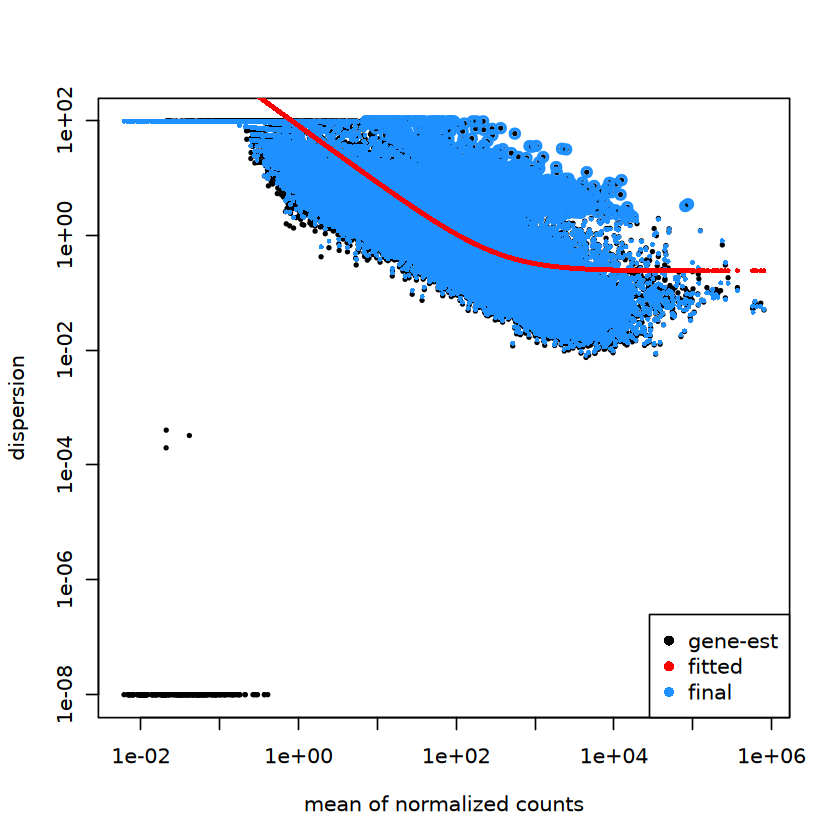

In [11]:
plotDispEsts(dds)

## nMDS
normalize and transform DESeq object using csv (variance stabilized expression matrix)

In [10]:
# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

B1_B1_O01 B1_W5_O50 B2_B5_O51 B2_C4_O40 B3_B4_O41 B3_C3_O30 B3_C6_O66
B1_B1_O01   0.0000  112.87364 115.3262  107.89794 115.25554 113.48167 122.9179 
B1_W5_O50 112.8736    0.00000 109.3705   92.94934  92.51608  97.48152 101.4467 
B2_B5_O51 115.3262  109.37055   0.0000  115.95337 111.82418 118.24287 112.7788 
B2_C4_O40 107.8979   92.94934 115.9534    0.00000  99.34984  96.00067 108.4873 
B3_B4_O41 115.2555   92.51608 111.8242   99.34984   0.00000 105.68102 108.0776 
B3_C3_O30 113.4817   97.48152 118.2429   96.00067 105.68102   0.00000 114.2894 
          B3_H4_O41 B3_W1_O06 B3_W4_O41 ⋯ W4_W5_G56 W5_B2_G21 W5_C4_G45
B1_B1_O01 116.1678  114.67824 105.7388  ⋯ 131.0135  110.9503   95.3255 
B1_W5_O50 113.4727  106.26615 106.0474  ⋯ 108.4771  117.2177  110.3544 
B2_B5_O51 125.5576  128.07360 123.0549  ⋯ 117.1577  129.0589  121.7444 
B2_C4_O40 111.2476  112.74691 100.7027  ⋯ 114.3448  111.0231  107.5110 
B3_B4_O41 119.5018   97.63448 111.9091  ⋯ 107.0356  120.5420  112.3259 
B3_C3_O30 119.6456  115.27810 111.7599  ⋯ 120.7426  118.9125  108.0603 
          W5_H4_G46 W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71 W6_W3_G36 W6_W4_G48
B1_B1_O01 104.5872  101.6345  105.9910  123.9108  108.3290  104.35939 129.5139 
B1_W5_O50 111.4573  111.7282  110.5900  114.0655  110.8031  104.15168 109.1279 
B2_B5_O51 105.0726  118.6173  123.0947  119.5198  123.0654  116.52978 109.4809 
B2_C4_O40 108.3220  106.9164  106.7425  121.0028  105.3548   84.68172 116.2580 
B3_B4_O41 113.9681  117.6559  115.5445  110.0930  115.2253  108.74247 109.6183 
B3_C3_O30 115.0886  114.8697  112.1972  126.0074  108.2107  108.42614 123.0013

X1         X2         Phase1_treatment Phase1_temp Phase1_DO
B1_B1_O01  14.051733  16.698775 both             warm        hypoxic  
B1_W5_O50  -3.585329 -22.358652 both             warm        hypoxic  
B2_B5_O51 -20.966187  -9.778556 both             warm        hypoxic  
B2_C4_O40   6.786560 -11.905661 both             warm        hypoxic  
B3_B4_O41 -11.624562 -19.641997 both             warm        hypoxic  
B3_C3_O30   8.824681  -8.946989 both             warm        hypoxic  
          Phase1_TankRep Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 1              both             warm        hypoxic   1             
B1_W5_O50 1              warm             warm        normoxic  5             
B2_B5_O51 2              both             warm        hypoxic   5             
B2_C4_O40 2              control          ambient     normoxic  4             
B3_B4_O41 3              both             warm        hypoxic   4             
B3_C3_O30 3              control          ambient     normoxic  3             
          complete_trtmt sizeFactor
B1_B1_O01 both both      1.0714460 
B1_W5_O50 both warm      1.0125468 
B2_B5_O51 both both      1.0641357 
B2_C4_O40 both control   1.1577371 
B3_B4_O41 both both      0.8702869 
B3_C3_O30 both control   0.8565139

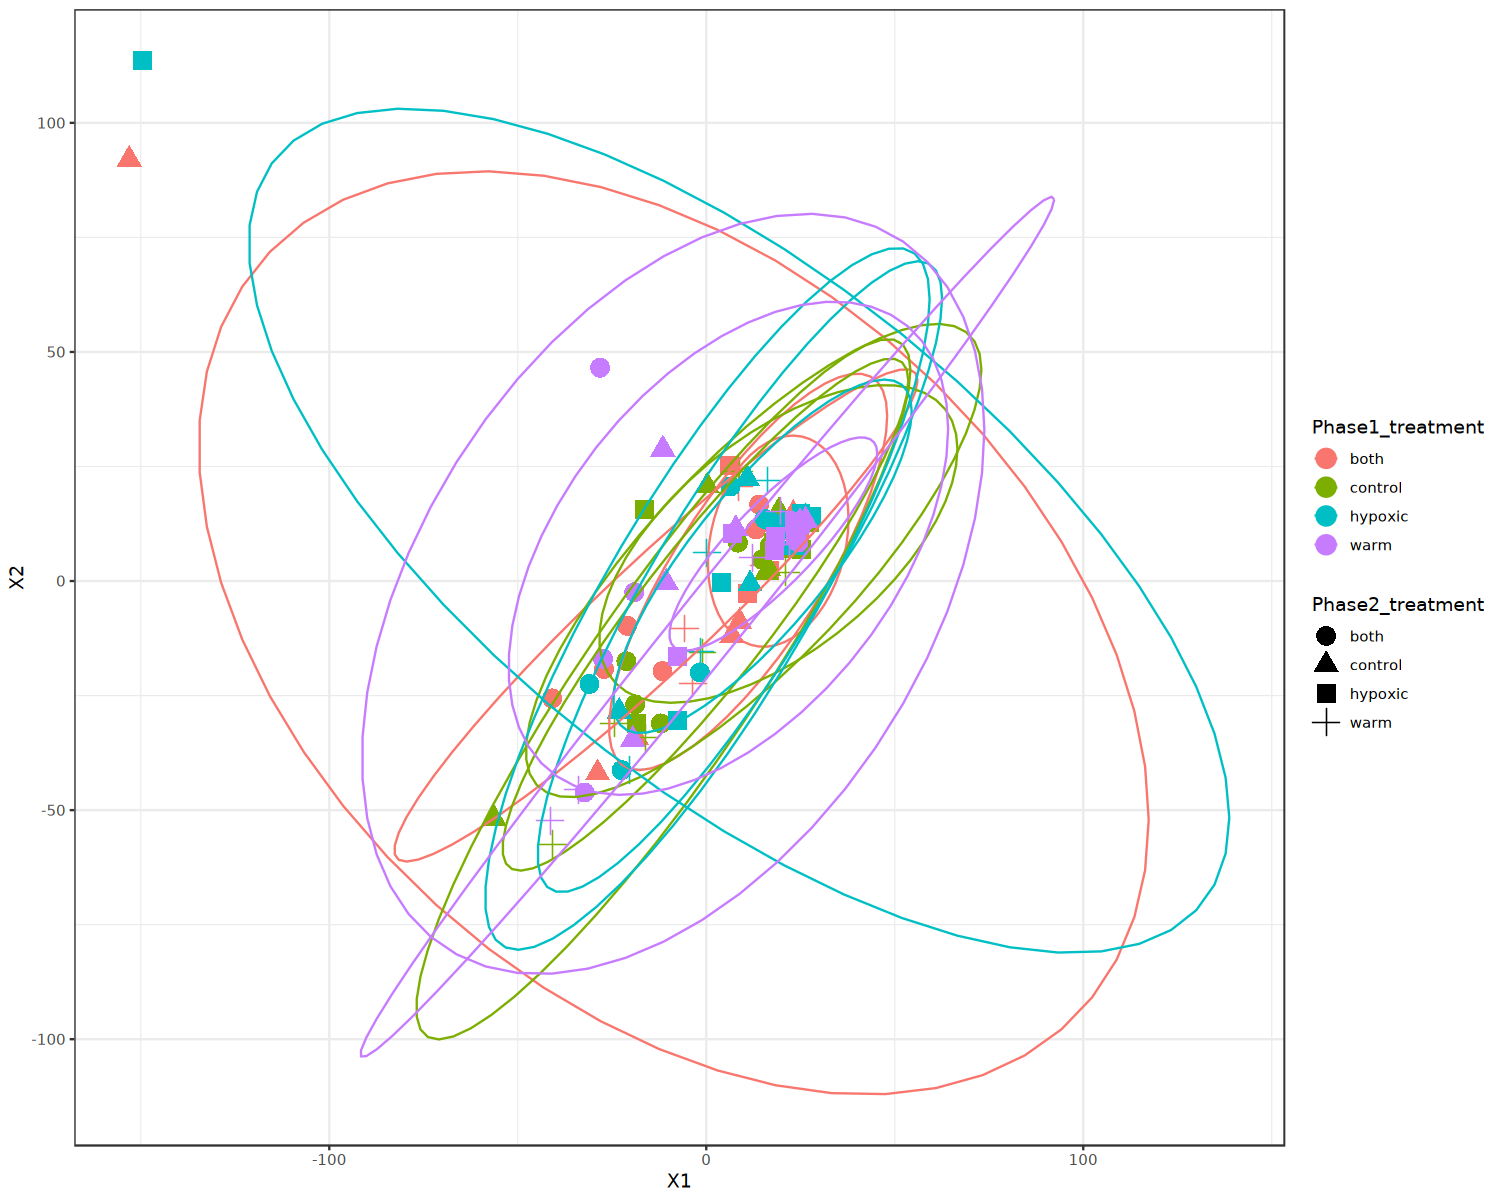

In [17]:
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_treatment, shape = Phase2_treatment)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw()

nmds.plot

attempting to make the above plot a little more legible by facetting/coloring and shaping by phase water treatments - but not sure if this actually just makes things more confusing/not the right way to show this

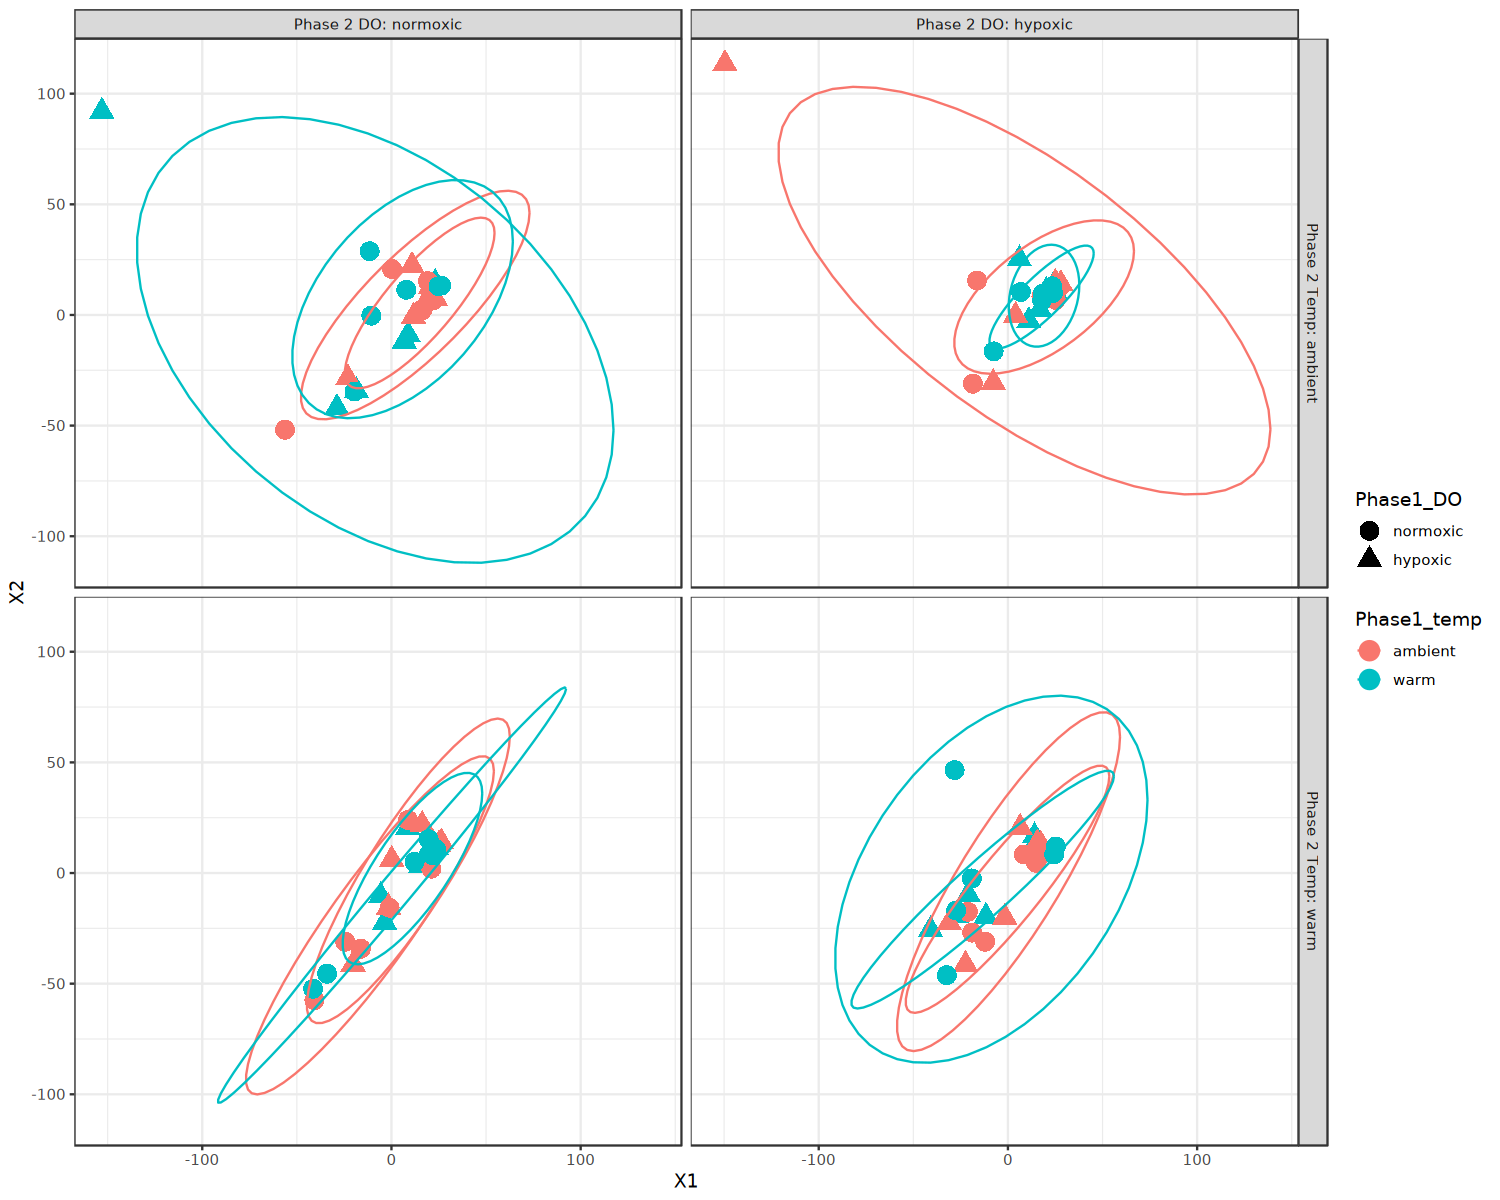

In [23]:
options(repr.plot.width=12.5, repr.plot.height=10)

# faceted by Phase 2 treatment
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_temp, shape = Phase1_DO)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw() + 
facet_grid(Phase2_temp ~ Phase2_DO,
           labeller = labeller(
      Phase2_temp = function(x) paste("Phase 2 Temp:", x),
      Phase2_DO   = function(x) paste("Phase 2 DO:", x)
    )
           )

nmds.plot

when phase 2 is normoxic and warm (Warm treatment) - the points are all on top of each other, with very little dispersion

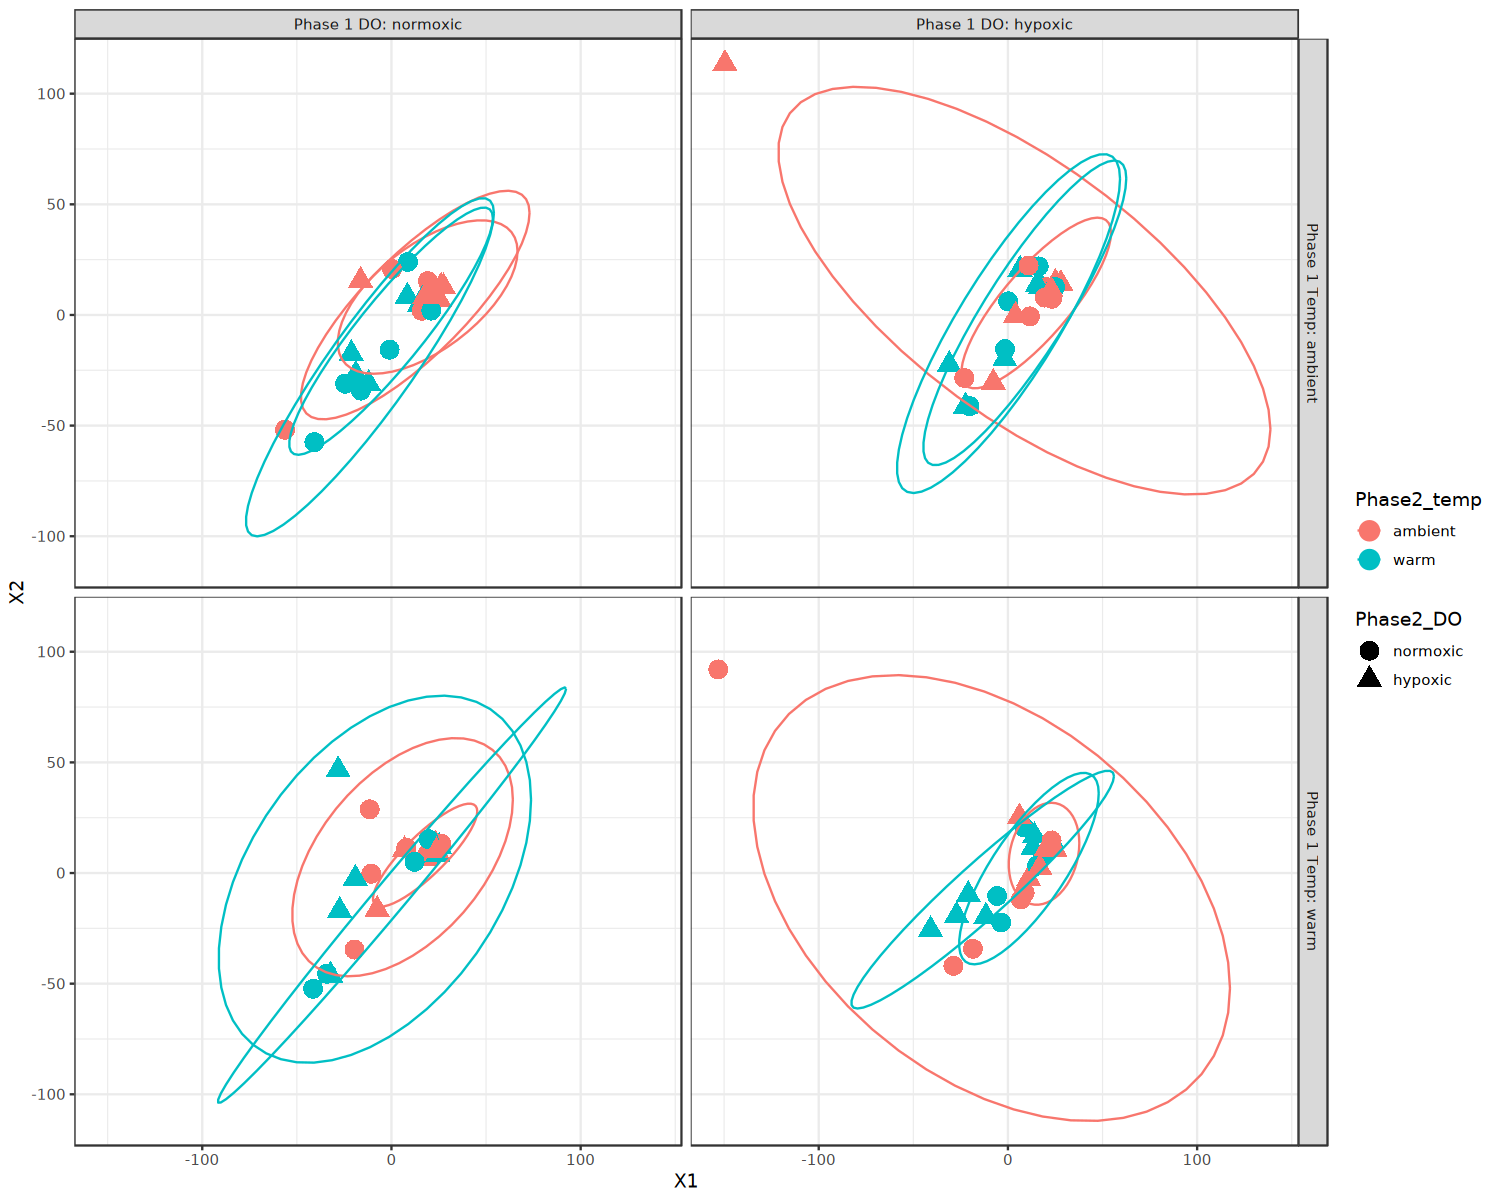

In [24]:
options(repr.plot.width=12.5, repr.plot.height=10)

# faceted by Phase 1 treatment
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase2_temp, shape = Phase2_DO)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw() + 
facet_grid(Phase1_temp ~ Phase1_DO,
           labeller = labeller(
      Phase1_temp = function(x) paste("Phase 1 Temp:", x),
      Phase1_DO   = function(x) paste("Phase 1 DO:", x)
    )
           )

nmds.plot

## permANOVA

In [17]:
sample_dists <- dist(t(assay(vsd)))  # transpose so samples are rows
head(sample_dists)

meta <- as.data.frame(colData(vsd))
head(meta)

[1] 112.8736 115.3262 107.8979 115.2555 113.4817 122.9179

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
B2_B5_O51 both             warm        hypoxic   2             
B2_C4_O40 both             warm        hypoxic   2             
B3_B4_O41 both             warm        hypoxic   3             
B3_C3_O30 both             warm        hypoxic   3             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
B1_B1_O01 both             warm        hypoxic   1              both both     
B1_W5_O50 warm             warm        normoxic  5              both warm     
B2_B5_O51 both             warm        hypoxic   5              both both     
B2_C4_O40 control          ambient     normoxic  4              both control  
B3_B4_O41 both             warm        hypoxic   4              both both     
B3_C3_O30 control          ambient     normoxic  3              both control  
          sizeFactor
B1_B1_O01 1.0714460 
B1_W5_O50 1.0125468 
B2_B5_O51 1.0641357 
B2_C4_O40 1.1577371 
B3_B4_O41 0.8702869 
B3_C3_O30 0.8565139

In [18]:
adonis2(sample_dists ~ Phase1_temp * Phase1_DO * Phase2_temp * Phase2_DO, data = meta, permutations = 999)

Df SumOfSqs   R2          F        
Phase1_temp                                  1   6436.659 0.009290143 0.8849709
Phase1_DO                                    1   5969.374 0.008615702 0.8207242
Phase2_temp                                  1  13573.403 0.019590729 1.8661956
Phase2_DO                                    1   9153.680 0.013211666 1.2585317
Phase1_temp:Phase1_DO                        1   5134.389 0.007410554 0.7059228
Phase1_temp:Phase2_temp                      1   5290.850 0.007636376 0.7274345
Phase1_DO:Phase2_temp                        1   6350.438 0.009165698 0.8731164
Phase1_temp:Phase2_DO                        1   6029.998 0.008703202 0.8290594
Phase1_DO:Phase2_DO                          1   6800.014 0.009814579 0.9349282
Phase2_temp:Phase2_DO                        1   9477.392 0.013678885 1.3030385
Phase1_temp:Phase1_DO:Phase2_temp            1   6584.395 0.009503372 0.9052828
Phase1_temp:Phase1_DO:Phase2_DO              1   6939.121 0.010015355 0.9540539
Phase1_temp:Phase2_temp:Phase2_DO            1   8889.284 0.012830059 1.2221801
Phase1_DO:Phase2_temp:Phase2_DO              1   8016.276 0.011570032 1.1021510
Phase1_temp:Phase1_DO:Phase2_temp:Phase2_DO  1   6338.892 0.009149034 0.8715289
Residual                                    80 581864.090 0.839814612        NA
Total                                       95 692848.257 1.000000000        NA
                                            Pr(>F)
Phase1_temp                                 0.681 
Phase1_DO                                   0.827 
Phase2_temp                                 0.005 
Phase2_DO                                   0.120 
Phase1_temp:Phase1_DO                       0.971 
Phase1_temp:Phase2_temp                     0.937 
Phase1_DO:Phase2_temp                       0.698 
Phase1_temp:Phase2_DO                       0.820 
Phase1_DO:Phase2_DO                         0.568 
Phase2_temp:Phase2_DO                       0.094 
Phase1_temp:Phase1_DO:Phase2_temp           0.633 
Phase1_temp:Phase1_DO:Phase2_DO             0.498 
Phase1_temp:Phase2_temp:Phase2_DO           0.138 
Phase1_DO:Phase2_temp:Phase2_DO             0.260 
Phase1_temp:Phase1_DO:Phase2_temp:Phase2_DO 0.697 
Residual                                       NA 
Total                                          NA

- Phase2_temp has a significant effect on GE (P = 0.005) and explains ~1.9% of the variation in GE
- The interaction of Phase2_temp and Phase2_DO is nearly significant (P = 0.094) and explains ~1.3% of the variation in GE
- The majoirty of the variation in GE is not explained by the treatments (R2 = 0.84)

#### heatmap of sample-to-sample distances using the variance stabilizing transformed values
following [RNA-seq workflow](https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html) from Mike Love

In [17]:
# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- dist(t(assay(vsd)))
head(sample_dists)

[1] 112.8736 115.3262 107.8979 115.2555 113.4817 122.9179

In [18]:
library(pheatmap)
library(RColorBrewer)

In [19]:
head(vsd)

class: DESeqTransform 
dim: 6 96 
metadata(1): version
assays(1): ''
rownames(6): LOC111116054 LOC111126949 ... LOC111120752 LOC111128944
rowData names(78): baseMean baseVar ... maxCooks dispFit
colnames(96): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(10): Phase1_treatment Phase1_temp ... complete_trtmt
  sizeFactor

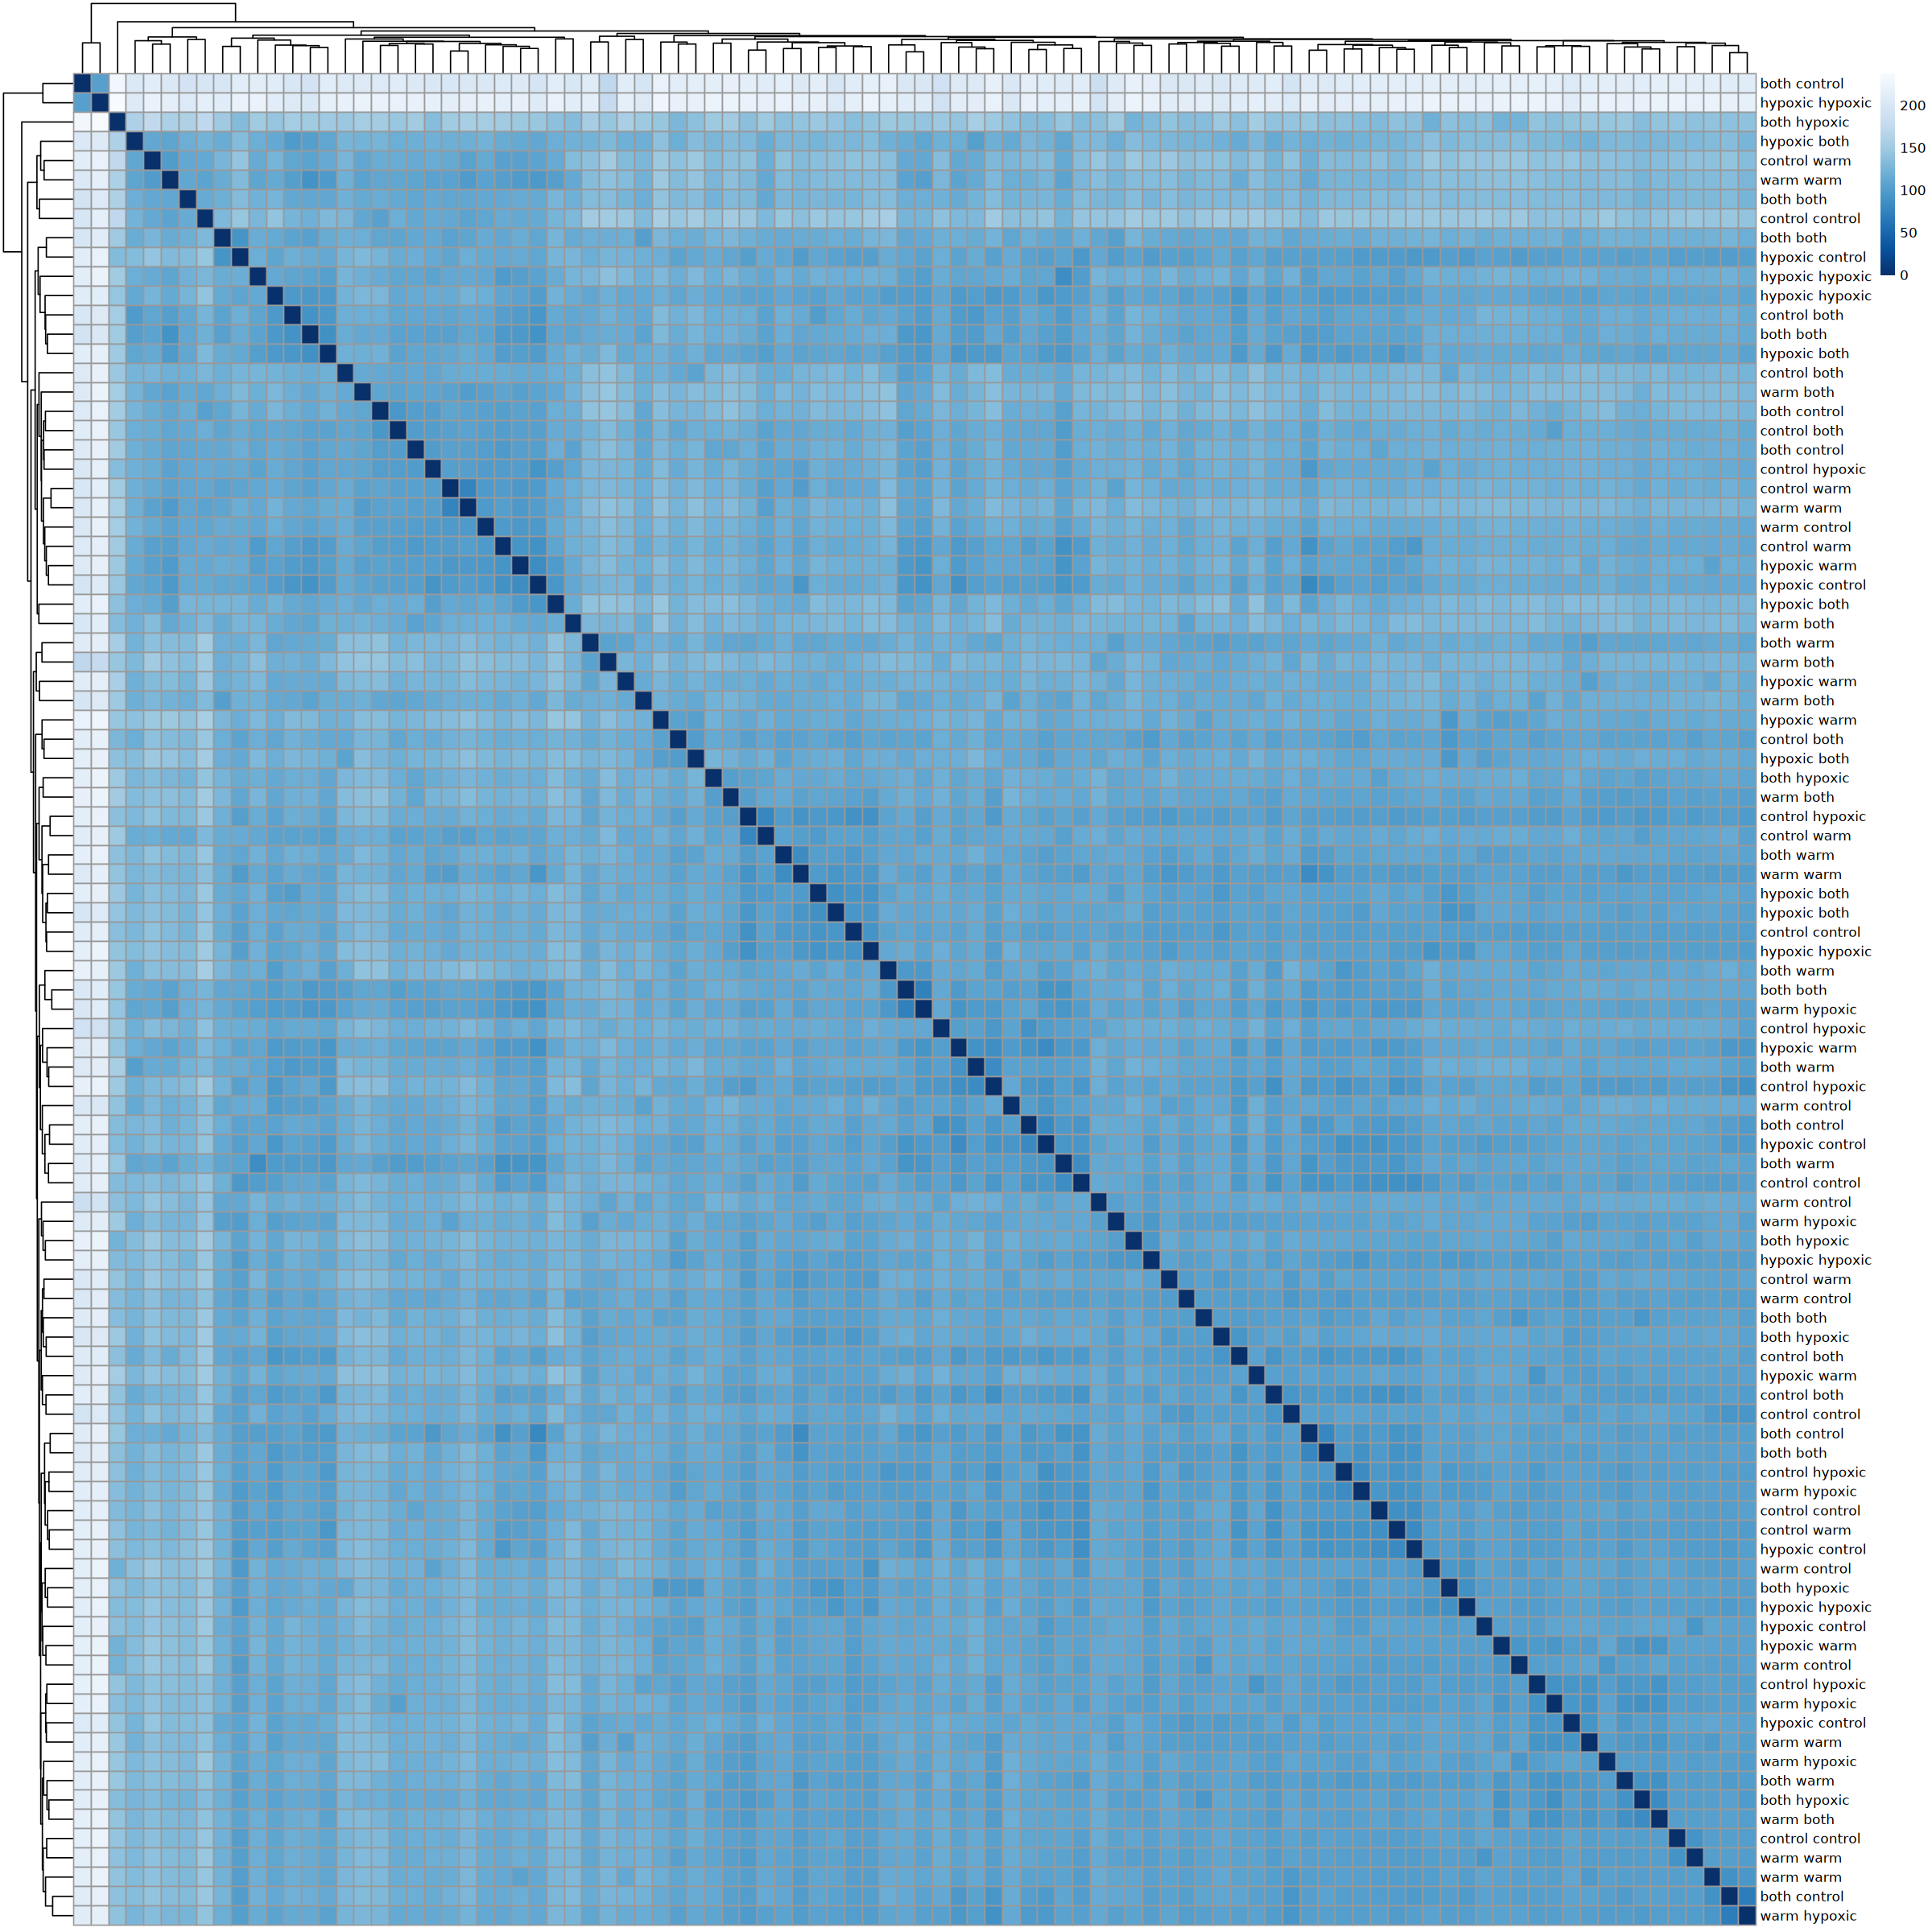

In [25]:
options(repr.plot.width=20, repr.plot.height=20)

sampleDistMatrix <- as.matrix(sample_dists)
rownames(sampleDistMatrix) <- paste(vsd$complete_trtmt)
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sample_dists,
         clustering_distance_cols = sample_dists,
         col = colors)

In [30]:
pcaData <- plotPCA(vsd, intgroup = c( "Phase1_treatment", "Phase2_treatment"), returnData = TRUE)
head(pcaData)

using ntop=500 top features by variance



PC1        PC2        group        Phase1_treatment Phase2_treatment
B1_B1_O01 -15.235433  -6.934442 both:both    both             both            
B1_W5_O50  14.849221   9.509118 both:warm    both             warm            
B2_B5_O51  18.444463 -10.028868 both:both    both             both            
B2_C4_O40   3.515344   7.850587 both:control both             control         
B3_B4_O41  17.977723   6.903814 both:both    both             both            
B3_C3_O30   0.971464   8.528714 both:control both             control         
          name     
B1_B1_O01 B1_B1_O01
B1_W5_O50 B1_W5_O50
B2_B5_O51 B2_B5_O51
B2_C4_O40 B2_C4_O40
B3_B4_O41 B3_B4_O41
B3_C3_O30 B3_C3_O30

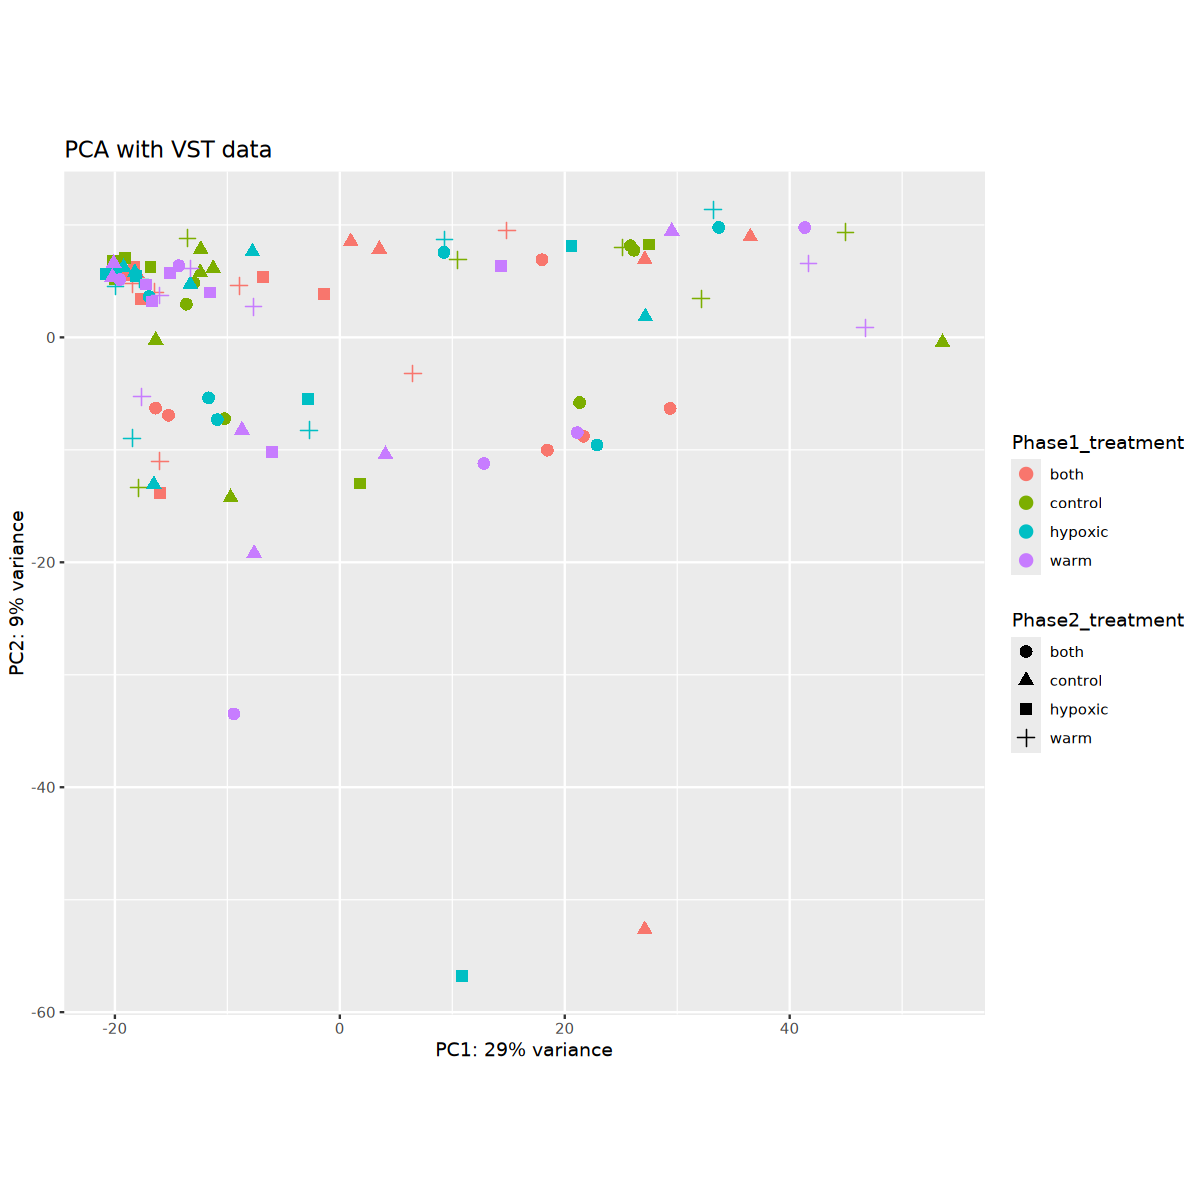

In [33]:
options(repr.plot.width=10, repr.plot.height=10)

percentVar <- round(100 * attr(pcaData, "percentVar"))

ggplot(pcaData, aes(x = PC1, y = PC2, color = Phase1_treatment, shape = Phase2_treatment)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed() +
  ggtitle("PCA with VST data")

## Pairwise comparisons

### 1. Effect of single exposure on GE after a period of recovery
- CC vs. WC
- CC vs. HC
- CC vs. BC

**CC vs. WC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 56, 0.16%
LFC < -1.00 (down) : 62, 0.18%



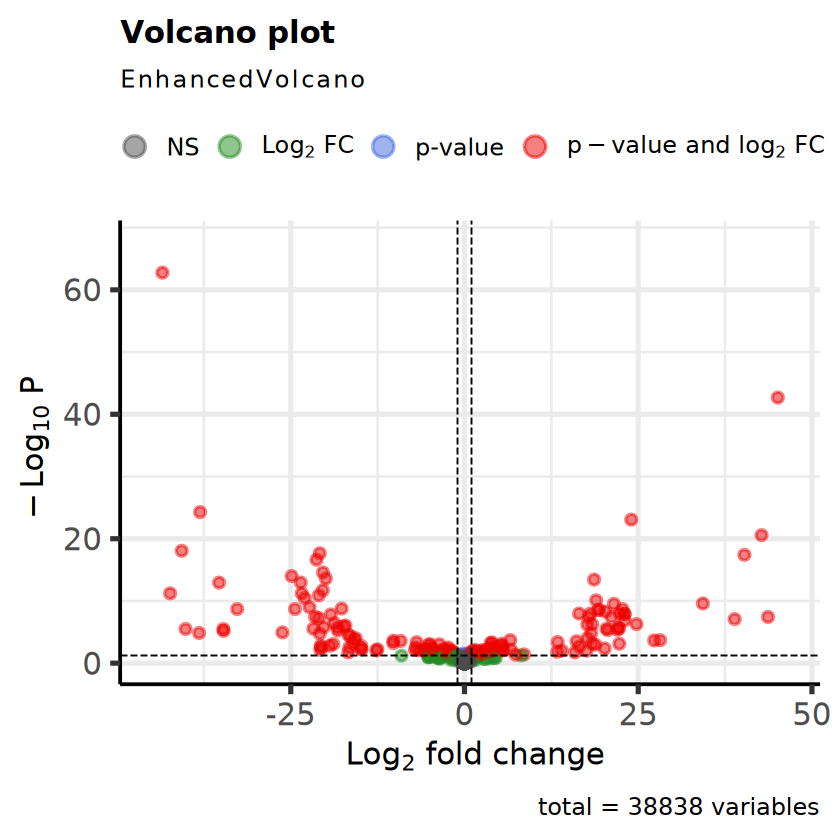

In [145]:
res.wc.cc <- lfcShrink(dds, 
                       contrast= c('complete_trtmt', 'warm.control', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wc.cc)

EnhancedVolcano(res.wc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [146]:
write.csv(res.wc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wc_cc.csv')

**CC vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 49, 0.14%
LFC < -1.00 (down) : 151, 0.43%



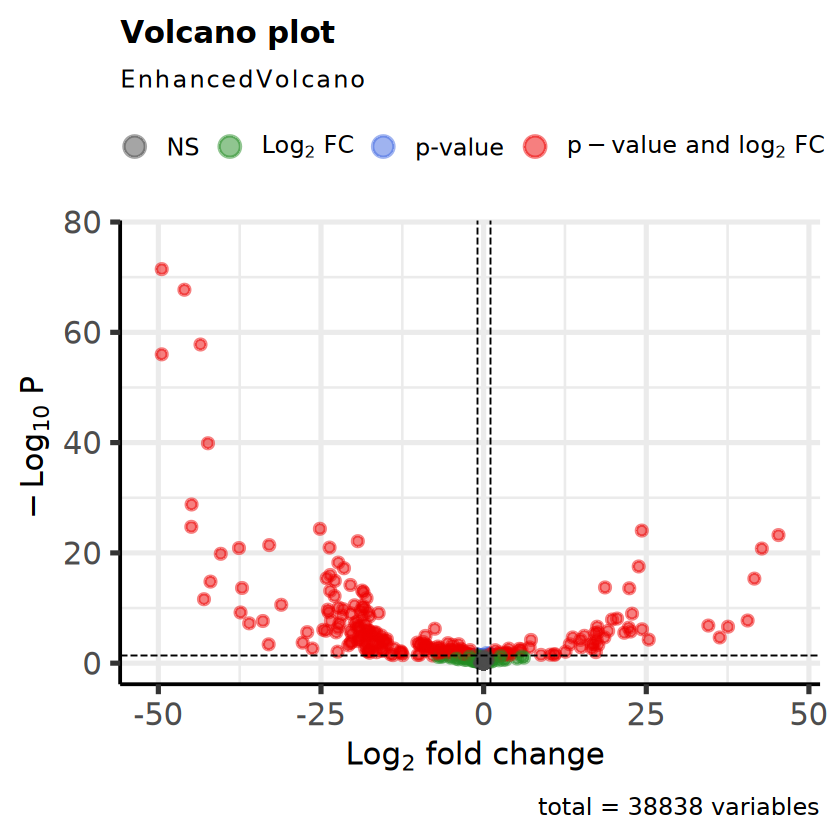

In [147]:
res.hc.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'hypoxic.control', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hc.cc)

EnhancedVolcano(res.hc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [148]:
write.csv(res.hc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hc_cc.csv')

**CC vs. BC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 254, 0.72%
LFC < -1.00 (down) : 42, 0.12%



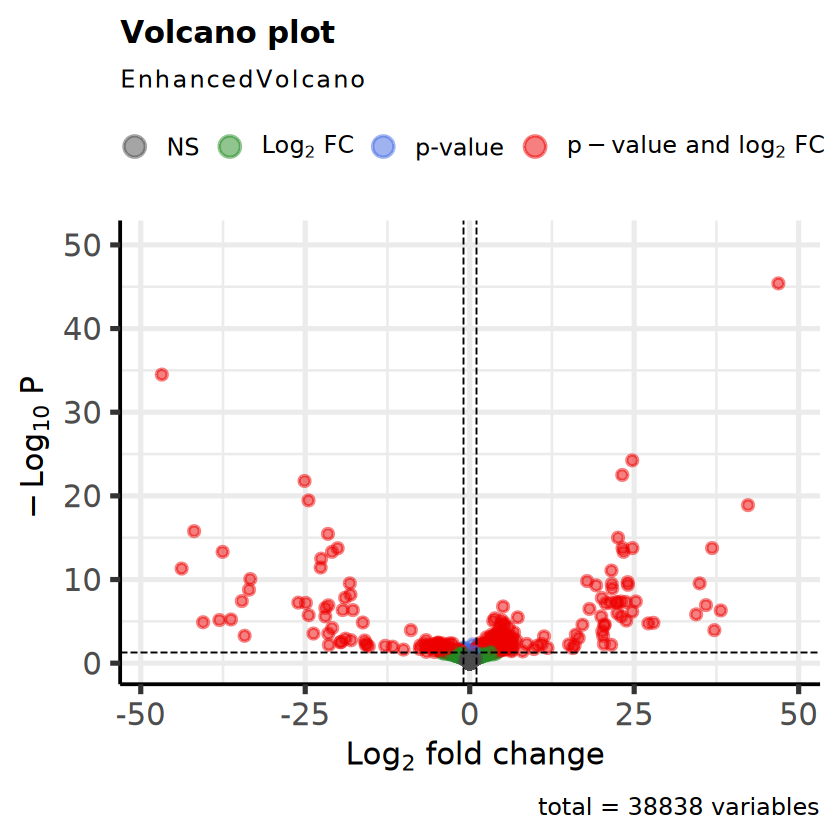

In [149]:
res.bc.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.control', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.cc)

EnhancedVolcano(res.bc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [150]:
write.csv(res.bc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_cc.csv')

### 2. Effect of single exposure experienced only later in life
- CC vs. CW
- CC vs. CH
- CC vs. CB

**CC vs. CW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 60, 0.17%
LFC < -1.00 (down) : 70, 0.2%



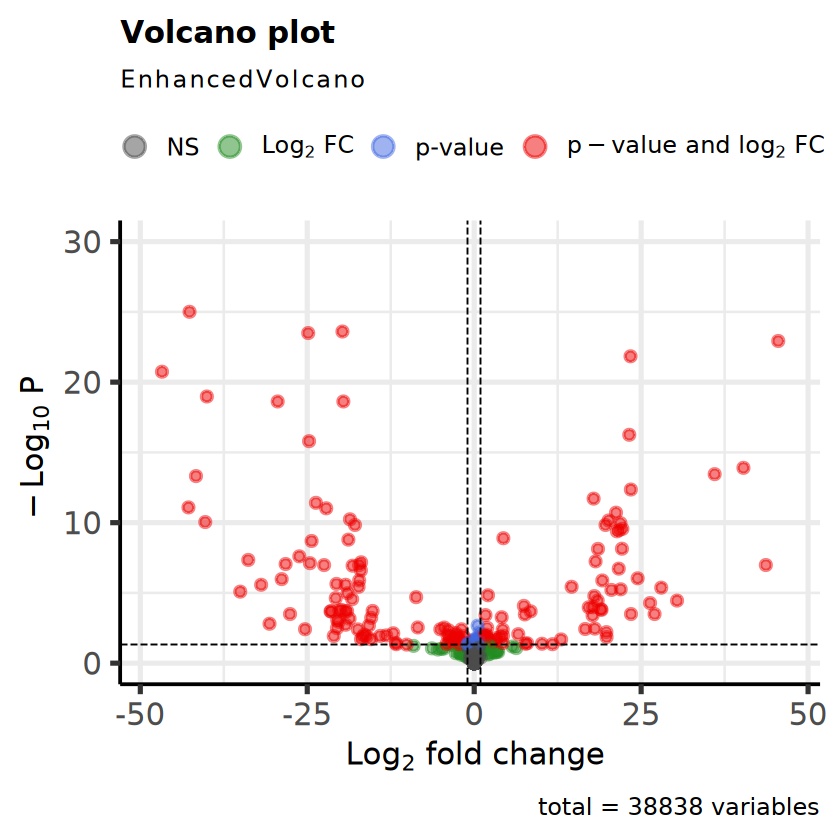

In [151]:
res.cw.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.warm', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cw.cc)

EnhancedVolcano(res.cw.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [152]:
write.csv(res.cw.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cw_cc.csv')

**CC vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 58, 0.16%
LFC < -1.00 (down) : 121, 0.34%



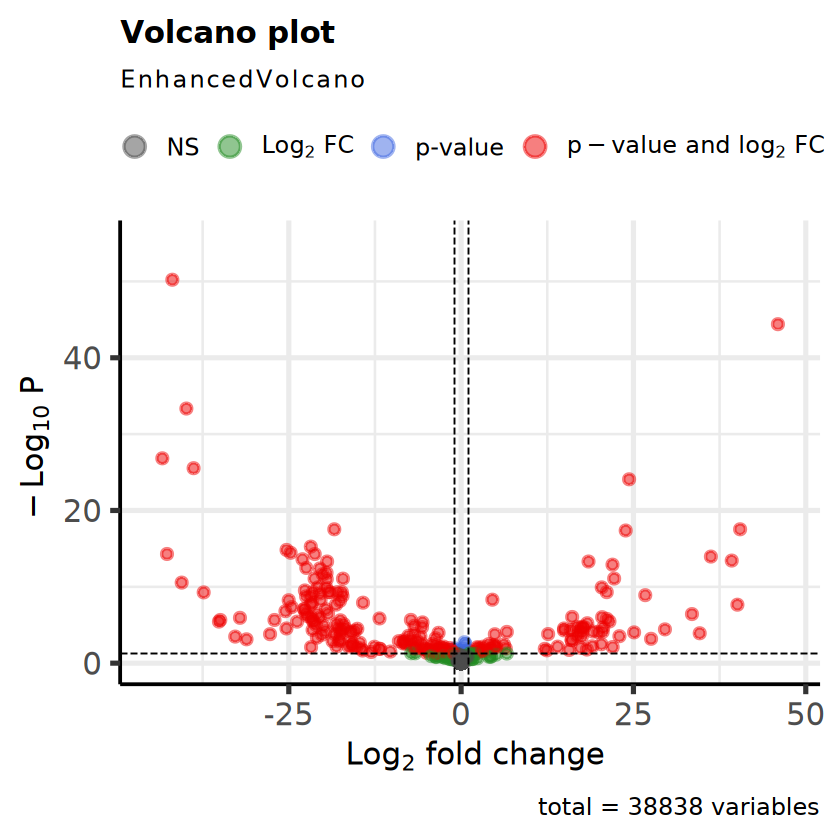

In [153]:
res.ch.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.hypoxic', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.ch.cc)

EnhancedVolcano(res.ch.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [154]:
write.csv(res.ch.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ch_cc.csv')

**CC vs. CB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 58, 0.16%
LFC < -1.00 (down) : 139, 0.39%



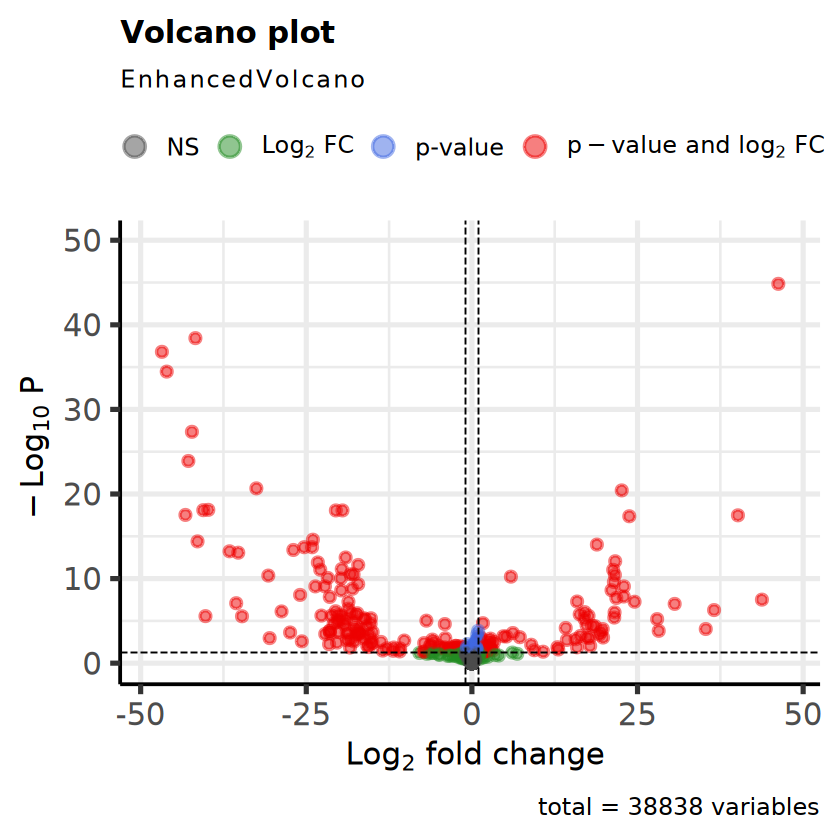

In [155]:
res.cb.cc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.both', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.cc)

EnhancedVolcano(res.cb.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [156]:
write.csv(res.cb.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_cc.csv')

### 3. Timing of Stress Exposure
How does GE change depending on when stress is experienced (when all oysters only experience stress once)?
- CH vs. HC
- CW vs. WC
- CB vs. BC

**CH vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 130, 0.37%
LFC < -1.00 (down) : 98, 0.28%



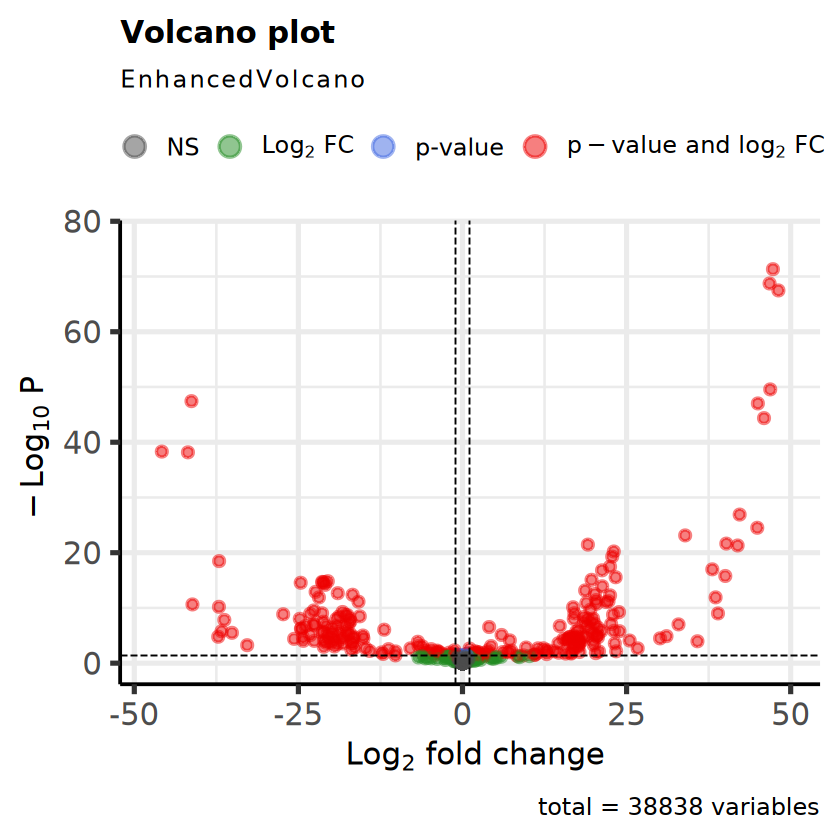

In [157]:
res.ch.hc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.hypoxic', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.ch.hc)

EnhancedVolcano(res.ch.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [158]:
write.csv(res.ch.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ch_hc.csv')

**CW vs. WC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 76, 0.21%
LFC < -1.00 (down) : 80, 0.23%



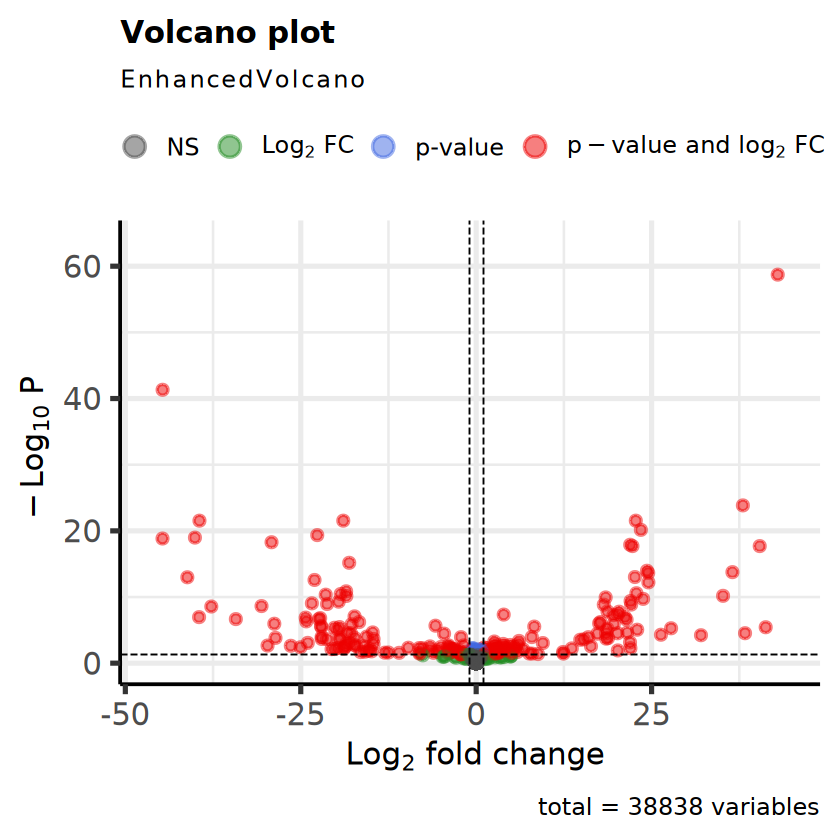

In [159]:
res.cw.wc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.warm', 'warm.control'), # WC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cw.wc)

EnhancedVolcano(res.cw.wc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [160]:
write.csv(res.cw.wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cw_wc.csv')

**CB vs. BC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 54, 0.15%
LFC < -1.00 (down) : 508, 1.4%



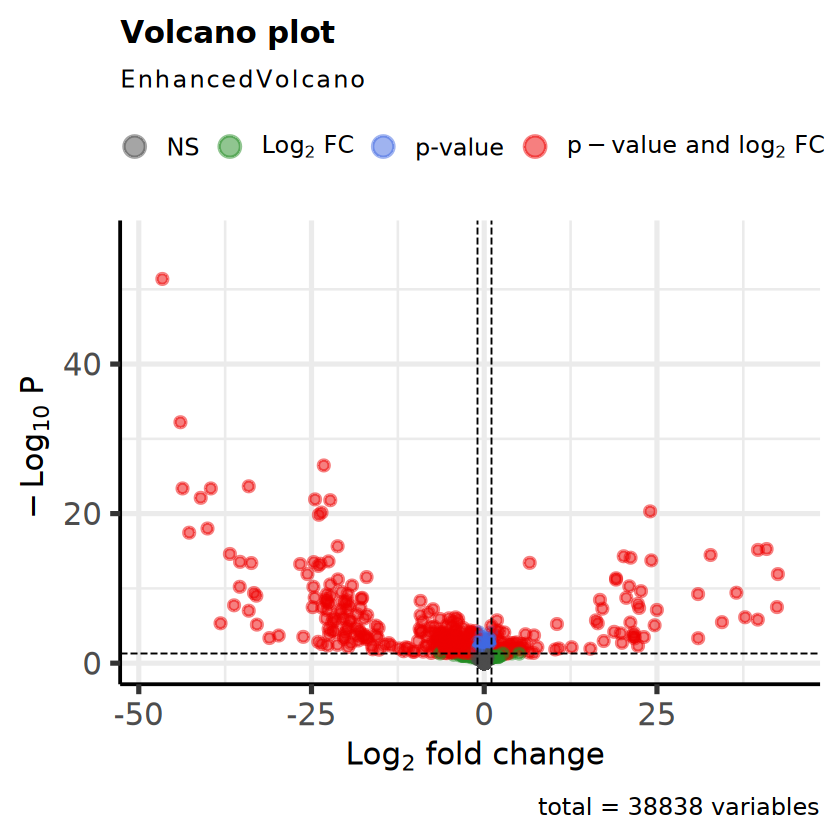

In [161]:
res.cb.bc <- lfcShrink(dds, contrast= c('complete_trtmt', 'control.both', 'both.control'), # BC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.bc)

EnhancedVolcano(res.cb.bc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [162]:
write.csv(res.cb.bc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_bc.csv')

### 4. No stress vs. most stress
- CC vs. WW
- CC vs. HH
- CC vs. BB

**CC vs. WW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 61, 0.17%
LFC < -1.00 (down) : 81, 0.23%



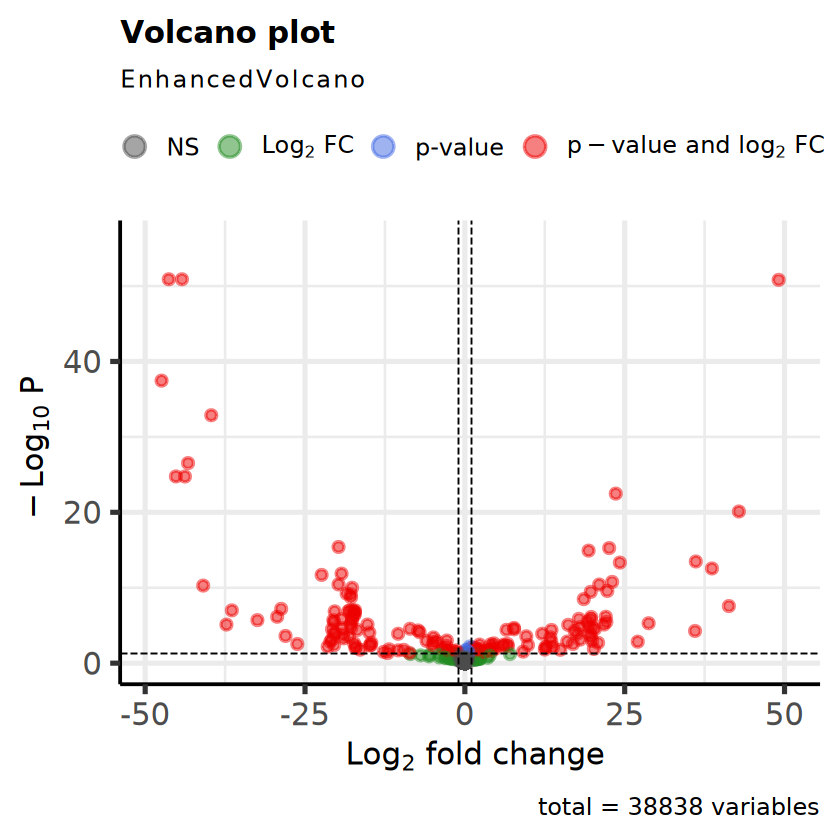

In [163]:
res.cc.ww <- lfcShrink(dds, contrast= c('complete_trtmt', 'warm.warm', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cc.ww)

EnhancedVolcano(res.cc.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [164]:
write.csv(res.cc.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ww_cc.csv')

**CC vs. HH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 387, 1.1%
LFC < -1.00 (down) : 99, 0.28%



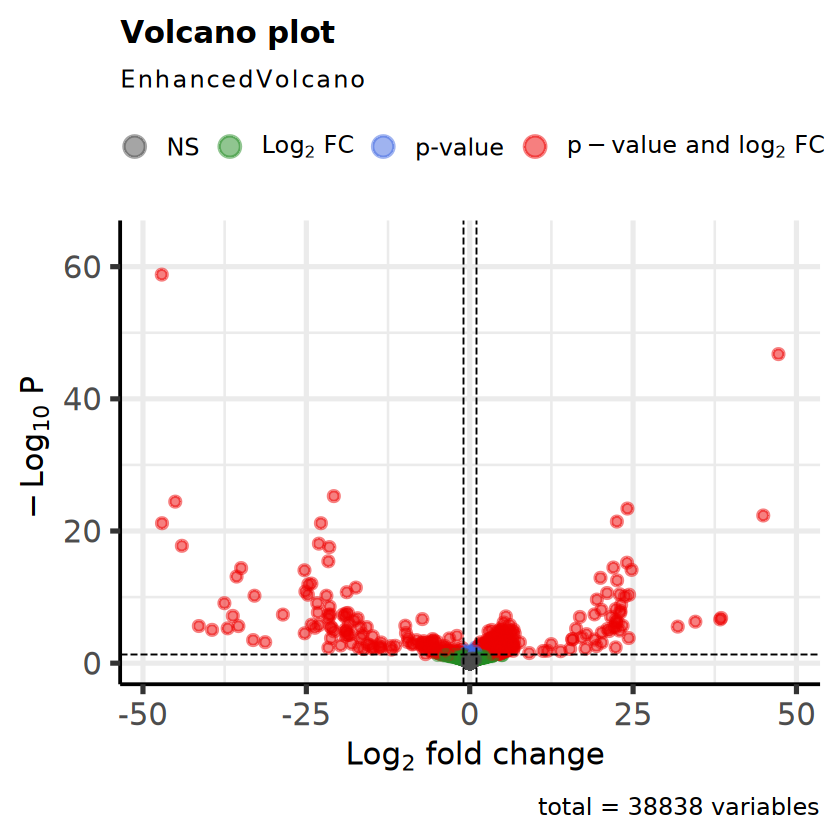

In [165]:
res.cc.hh <- lfcShrink(dds, contrast= c('complete_trtmt', 'hypoxic.hypoxic', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cc.hh)

EnhancedVolcano(res.cc.hh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [166]:
write.csv(res.cc.hh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hh_cc.csv')

**CC vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 41, 0.12%
LFC < -1.00 (down) : 61, 0.17%



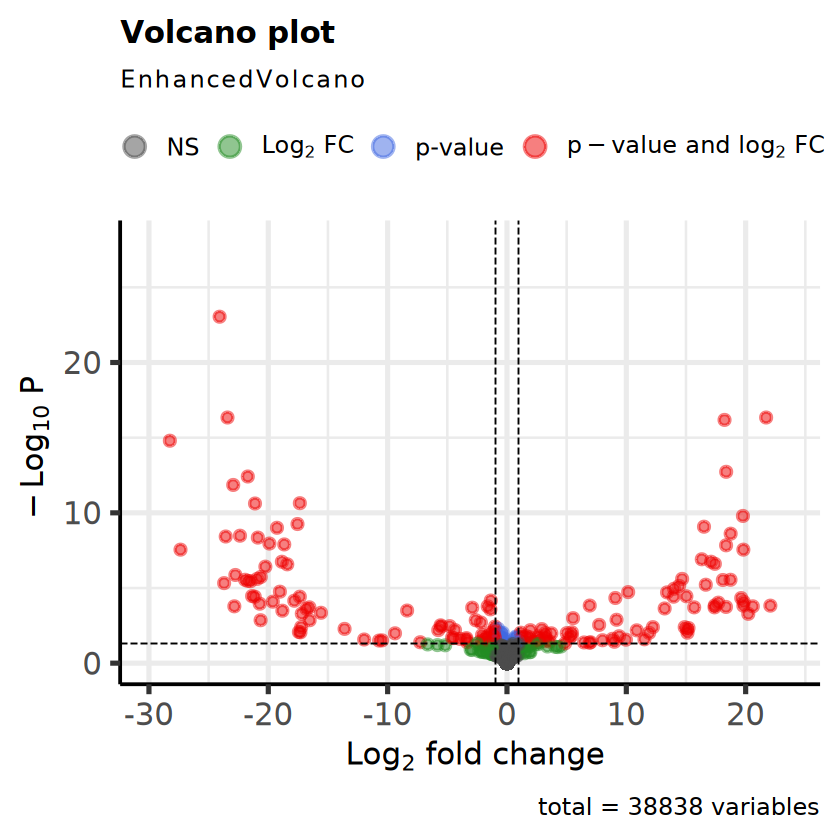

In [167]:
res.cc.bb <- lfcShrink(dds, coef='complete_trtmt_control.control_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cc.bb)

EnhancedVolcano(res.cc.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

switch LFC direction so CC is the baseline (deseq recognizes as bb as the baseline rn)

In [168]:
cc.bb.df <- as.data.frame(res.cc.bb) %>% # create df
mutate(log2FoldChange = log2FoldChange * -1) # multiple by -1 to make pos to neg and vice versa 

# validate
head(res.cc.bb)
head(cc.bb.df)

log2 fold change (MMSE): complete trtmt control.control vs both.both 
Wald test p-value: complete trtmt control.control vs both.both 
DataFrame with 6 rows and 7 columns
               baseMean log2FoldChange     lfcSE       stat    pvalue      padj
              <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
LOC111116054   8.953702    0.020208059 0.1242902  1.2677121 0.2049008  0.900172
LOC111126949 558.918843   -0.028168333 0.1024534 -1.2030773 0.2289464  0.916746
LOC111110729 112.702369    0.031708795 0.0904976  1.0020605 0.3163144  0.956939
LOC111112434   7.020693   -0.005088566 0.1132821 -0.4212178 0.6735960  0.998394
LOC111120752 427.481171    0.073296525 0.1248250  2.1786669 0.0293564  0.566228
LOC111128944   0.105887   -0.000295768 0.4242314 -0.0135484 0.9891903  0.998394
                svalue
             <numeric>
LOC111116054  0.971782
LOC111126949  0.987444
LOC111110729  0.990658
LOC111112434  0.984865
LOC111120752  0.983533
LOC111128944  0.966873

baseMean    log2FoldChange lfcSE      stat       pvalue    
LOC111116054   8.9537018 -0.0202080595  0.12429017  1.2677121 0.20490079
LOC111126949 558.9188428  0.0281683330  0.10245337 -1.2030773 0.22894641
LOC111110729 112.7023690 -0.0317087955  0.09049763  1.0020605 0.31631439
LOC111112434   7.0206931  0.0050885662  0.11328209 -0.4212178 0.67359602
LOC111120752 427.4811709 -0.0732965248  0.12482504  2.1786669 0.02935642
LOC111128944   0.1058866  0.0002957684  0.42423144 -0.0135484 0.98919027
             padj      svalue   
LOC111116054 0.9001718 0.9717822
LOC111126949 0.9167464 0.9874444
LOC111110729 0.9569395 0.9906581
LOC111112434 0.9983941 0.9848650
LOC111120752 0.5662278 0.9835328
LOC111128944 0.9983941 0.9668732

In [169]:
write.csv(cc.bb.df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv')

### 5. Effect of initial exposure on response in later exposure
(also gets at the effect of priming to stress)

#### 5A. Matched stressors
Oyster is primed with a stress, and experiences the *same* stressor again
- HH vs. CH
- WW vs. CW
- BB vs. CB

**HH vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 318, 0.9%
LFC < -1.00 (down) : 70, 0.2%



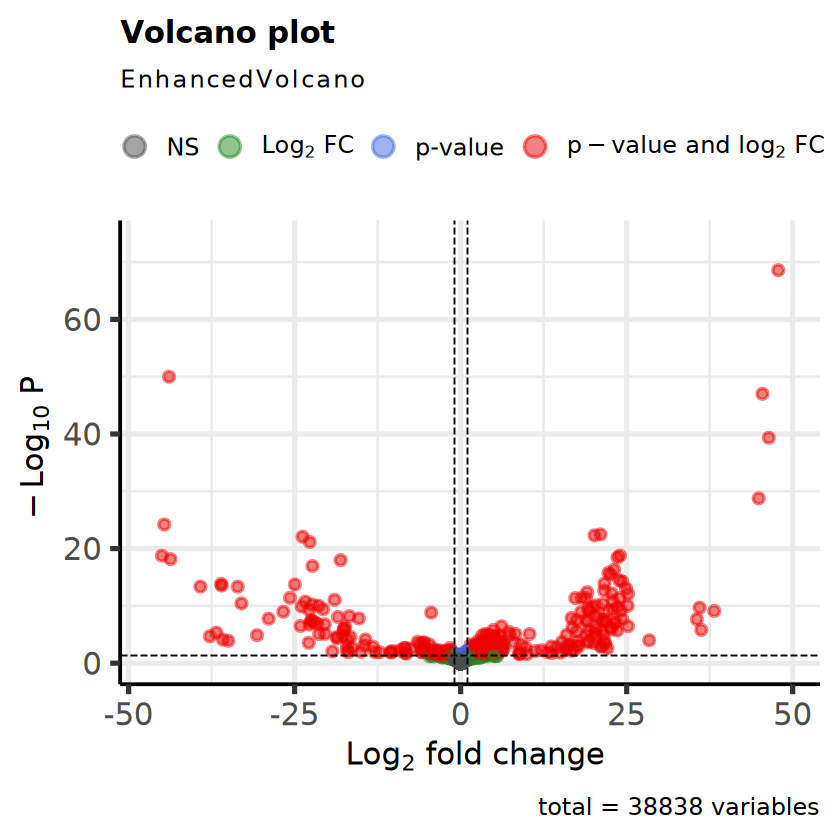

In [170]:
res.hh.ch <- lfcShrink(dds, contrast= c('complete_trtmt', 'hypoxic.hypoxic', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hh.ch)

EnhancedVolcano(res.hh.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [171]:
write.csv(res.hh.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hh_ch.csv')

**WW vs. CW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 67, 0.19%
LFC < -1.00 (down) : 71, 0.2%



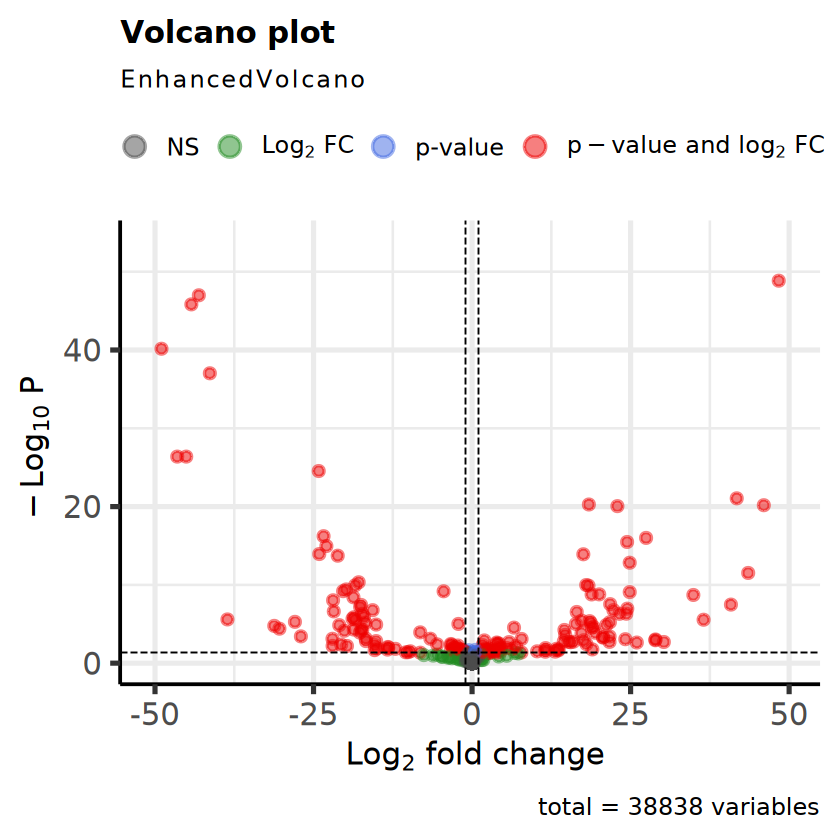

In [172]:
res.ww.cw <- lfcShrink(dds, contrast= c('complete_trtmt', 'warm.warm', 'control.warm'), # CW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.ww.cw)

EnhancedVolcano(res.ww.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [173]:
write.csv(res.ww.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ww_cw.csv')

**BB vs. CB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 42, 0.12%
LFC < -1.00 (down) : 146, 0.41%



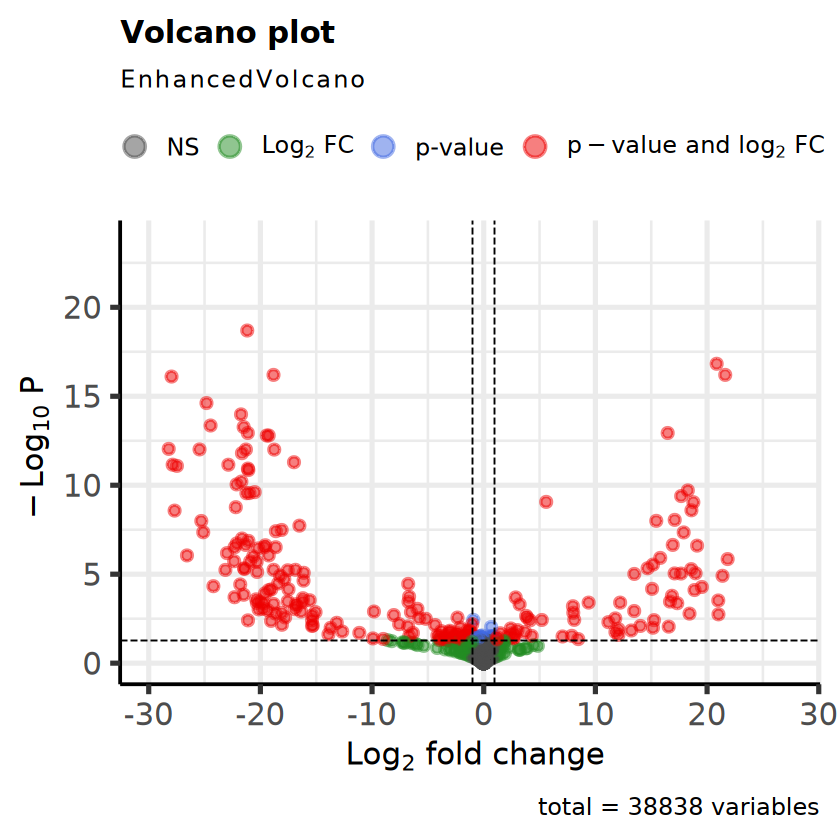

In [174]:
res.cb.bb <- lfcShrink(dds, 
                       coef= 'complete_trtmt_control.both_vs_both.both', # BB is the "control"
                       type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.bb)

EnhancedVolcano(res.cb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [175]:
write.csv(res.cb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_bb.csv')

#### 5B. Semi-matched priming: primed with single stress, later exposed to multiple stressors
- WB vs. CB
- HB vs. CB

**WB vs. CB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 174, 0.49%
LFC < -1.00 (down) : 54, 0.15%



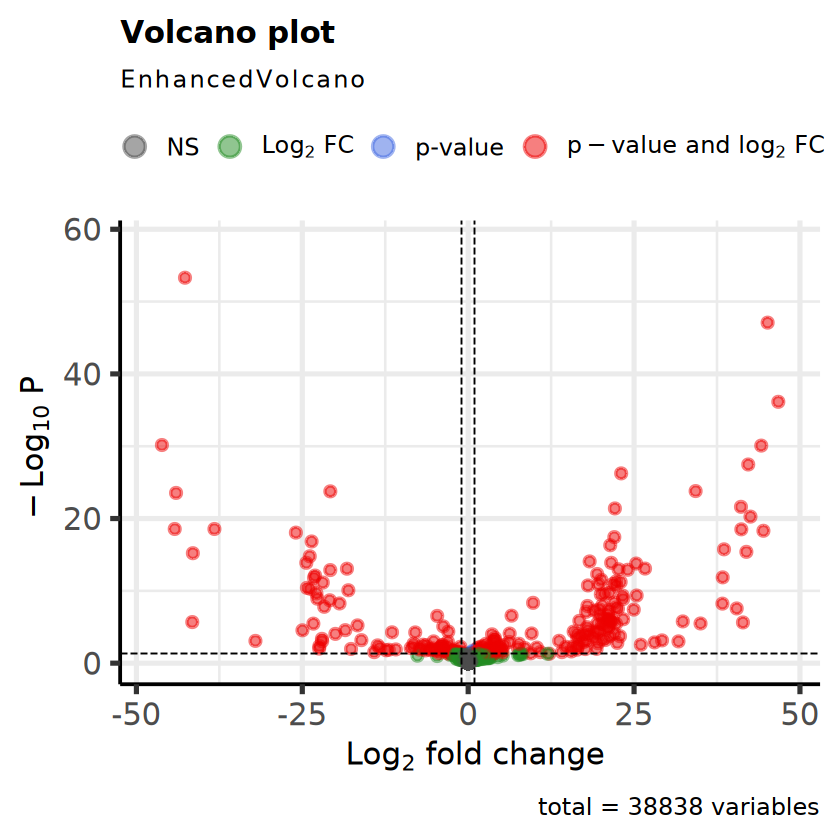

In [176]:
res.wb.cb <- lfcShrink(dds, contrast= c('complete_trtmt', 'warm.both', 'control.both'), # CB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.cb)

EnhancedVolcano(res.wb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [177]:
write.csv(res.wb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_cb.csv')

**HB vs. CB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 123, 0.35%
LFC < -1.00 (down) : 63, 0.18%



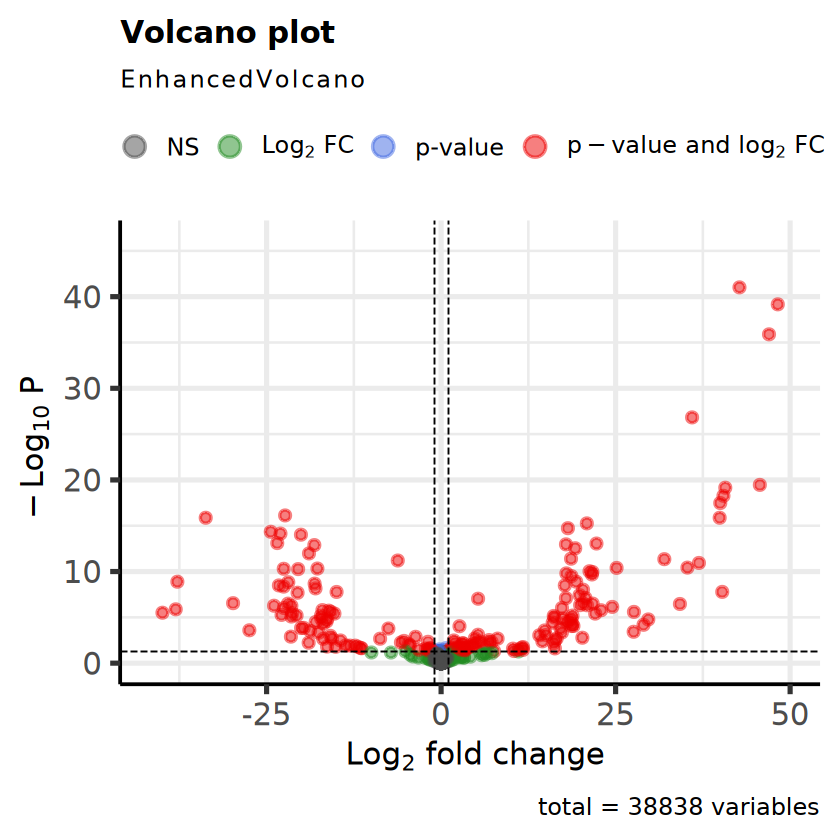

In [178]:
res.hb.cb <- lfcShrink(dds, contrast= c('complete_trtmt', 'hypoxic.both', 'control.both'), # CB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.cb)

EnhancedVolcano(res.hb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [179]:
write.csv(res.hb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_cb.csv')

#### 5C. Semi-matched priming: primed with multiple stressors, later exposed to single stress
- CB vs. WB
- CB vs. HB

**CB vs. WB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 174, 0.49%
LFC < -1.00 (down) : 54, 0.15%



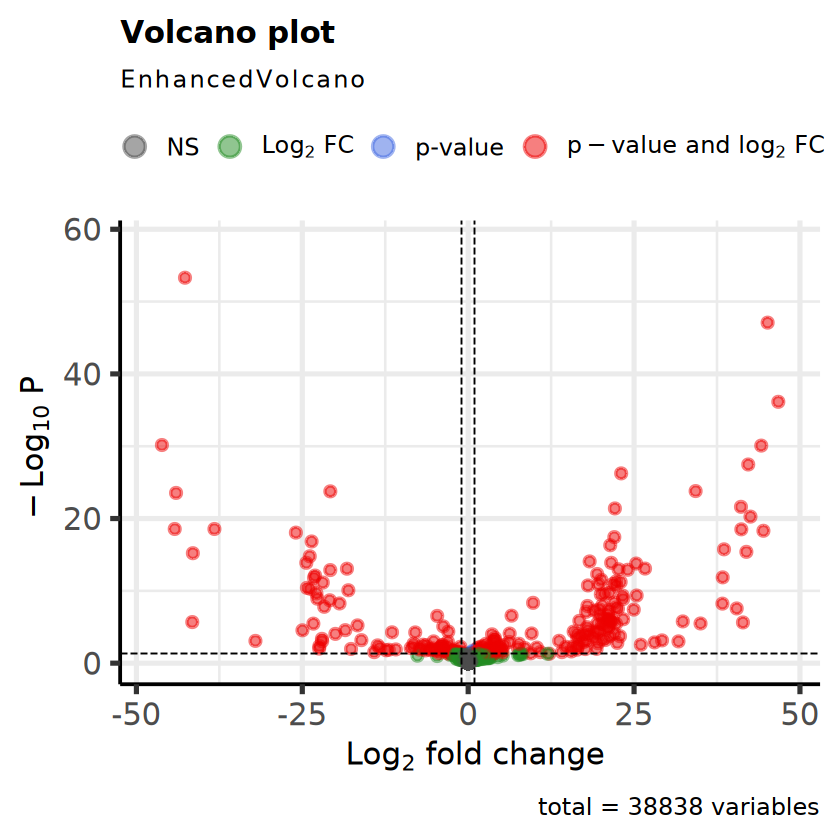

In [180]:
res.wb.cb <- lfcShrink(dds, contrast = c('complete_trtmt', 'warm.both', 'control.both'), # CB is the "control"
                       type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.cb)

EnhancedVolcano(res.wb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [181]:
write.csv(res.wb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_cb.csv')

**CB vs. HB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 123, 0.35%
LFC < -1.00 (down) : 63, 0.18%



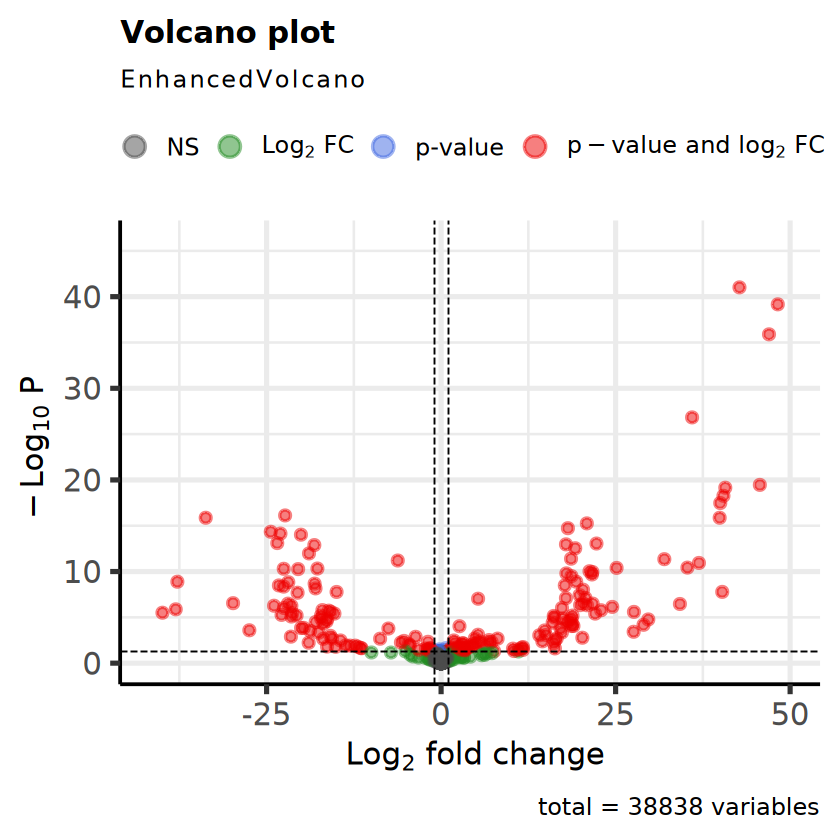

In [182]:
res.hb.cb <- lfcShrink(dds, contrast = c('complete_trtmt', 'hypoxic.both', 'control.both'), # CB is the "control"
                       type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.cb)

EnhancedVolcano(res.hb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [183]:
write.csv(res.hb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_cb.csv')

### 6. Effect of initial exposure on subsequent response to stress
Oysters all experience the same early stressor, but either return to that stressor or experience control conditions
- HC vs. HH
- WC vs. WW
- BB vs. BC

**HC vs. HH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 96, 0.27%
LFC < -1.00 (down) : 681, 1.9%



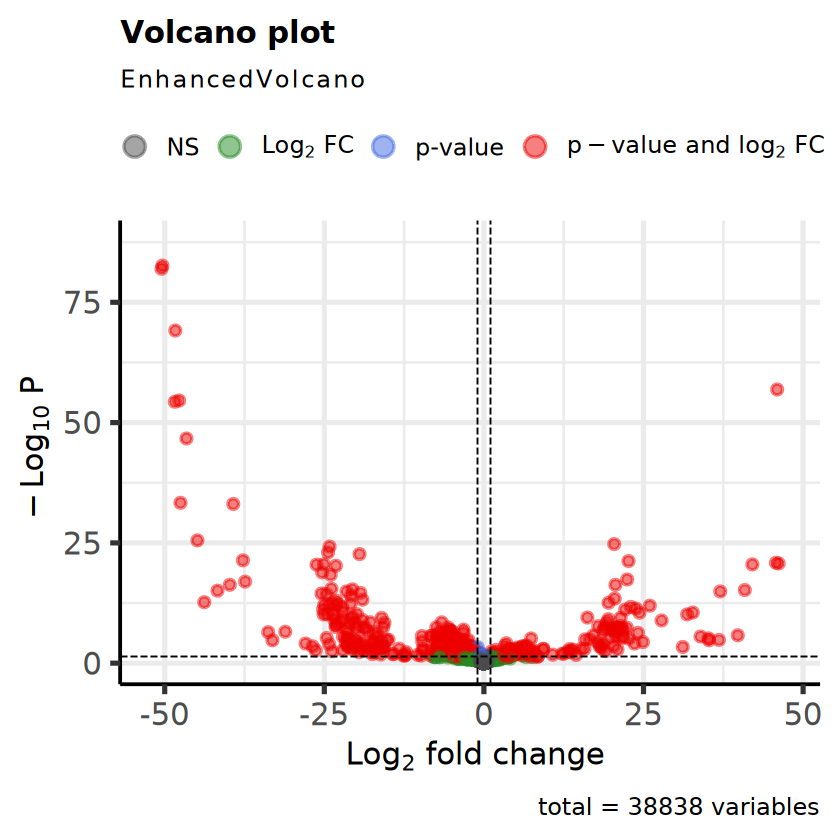

In [184]:
res.hc.hh <- lfcShrink(dds, contrast = c('complete_trtmt', 'hypoxic.control', 'hypoxic.hypoxic'), # HH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hc.hh)

EnhancedVolcano(res.hc.hh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [185]:
write.csv(res.hc.hh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hc_hh.csv')

**WC vs. WW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 86, 0.24%
LFC < -1.00 (down) : 81, 0.23%



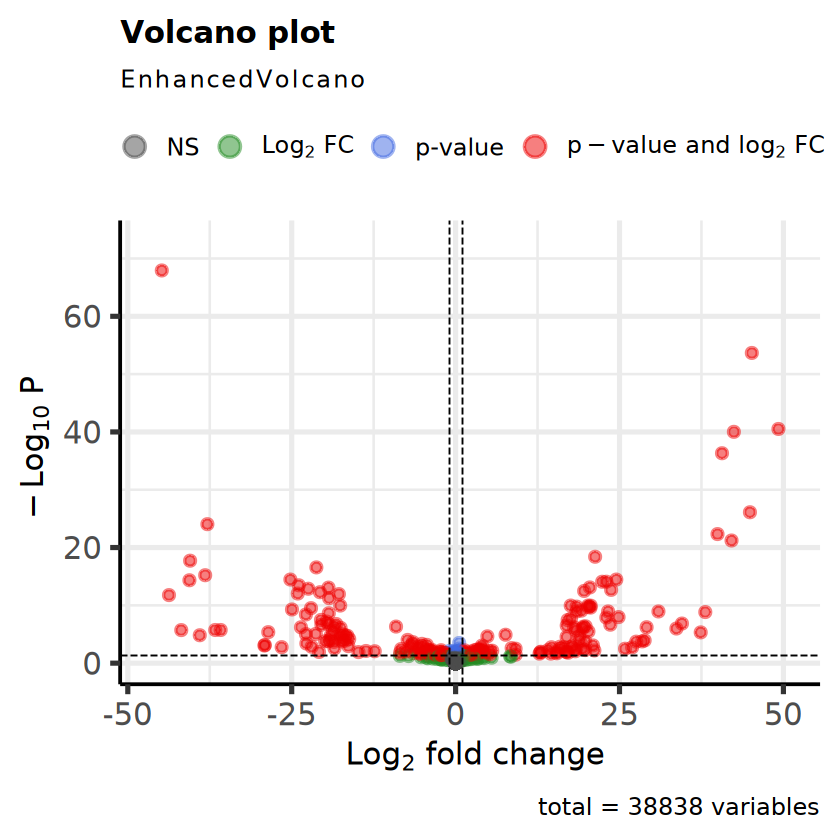

In [186]:
res.wc.ww <- lfcShrink(dds, contrast = c('complete_trtmt', 'warm.control', 'warm.warm'), # WW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wc.ww)

EnhancedVolcano(res.wc.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [187]:
write.csv(res.wc.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wc_ww.csv')

**BC vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 159, 0.45%
LFC < -1.00 (down) : 34, 0.096%



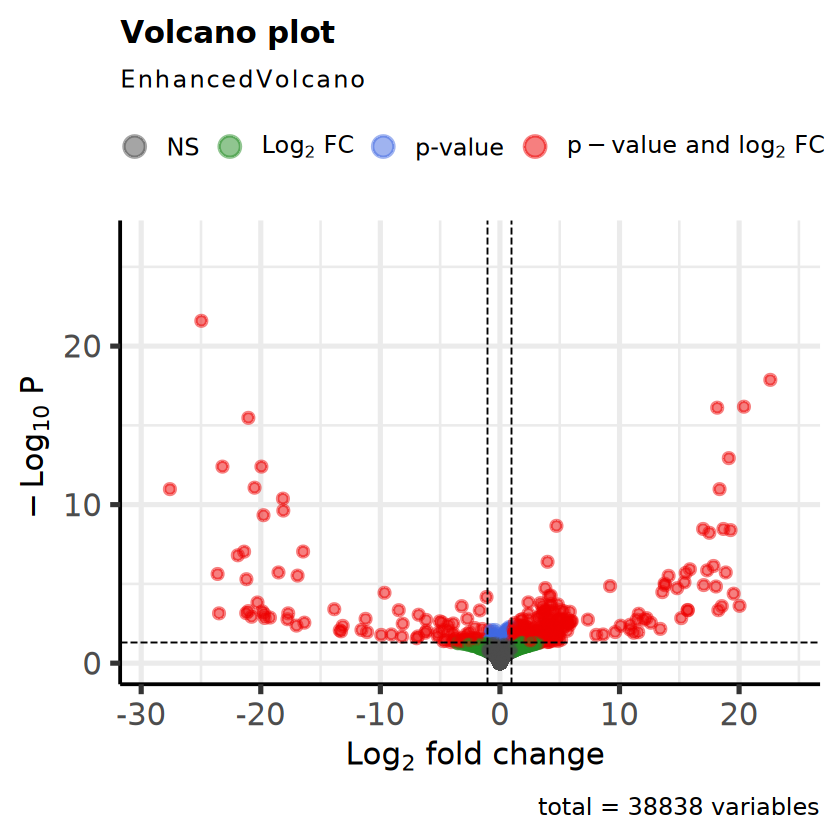

In [188]:
res.bc.bb <- lfcShrink(dds, coef = 'complete_trtmt_both.control_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.bb)

EnhancedVolcano(res.bc.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [189]:
write.csv(res.bc.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_bb.csv')

### 7. Effect of initial single/multiple stress on response in ...
Is it better to be primed with a single stressor or multiple stressor, depending on the context of the future enviornment (single/multiple stressor)?

#### 7A. ...later *single* stress
Oyster is primed with either multiple or a single stressors, and then experiences only a sinlge stressor later
- BH vs. HH
- BW vs. WW

**BH vs. HH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 80, 0.23%
LFC < -1.00 (down) : 759, 2.1%



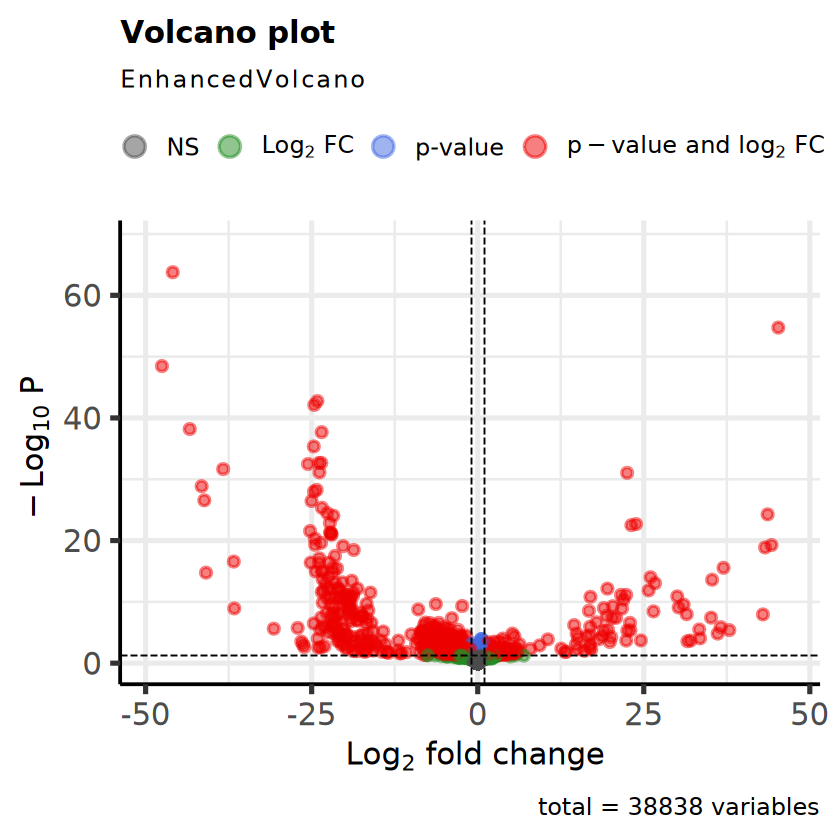

In [190]:
res.hh.bh <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.hypoxic', 'hypoxic.hypoxic'), # HH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hh.bh)

EnhancedVolcano(res.hh.bh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [191]:
write.csv(res.hh.bh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bh_hh.csv')

**BW vs. WW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 75, 0.21%
LFC < -1.00 (down) : 151, 0.43%



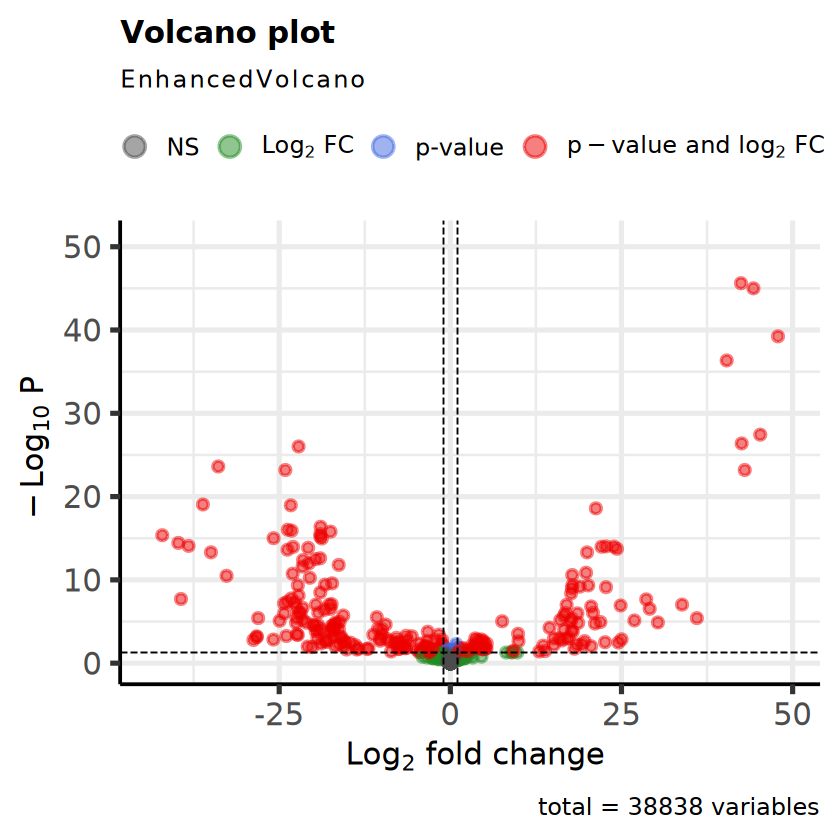

In [192]:
res.bw.ww <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.warm', 'warm.warm'), # WW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bw.ww)

EnhancedVolcano(res.bw.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [193]:
write.csv(res.bw.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bw_ww.csv')

#### 7B. ...later *multiple* stressors
Oyster is primed with either multiple or a single stressors, and then experiences multiple stressors later
- HB vs. BB
- WB vs. BB

**HB vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 51, 0.14%
LFC < -1.00 (down) : 92, 0.26%



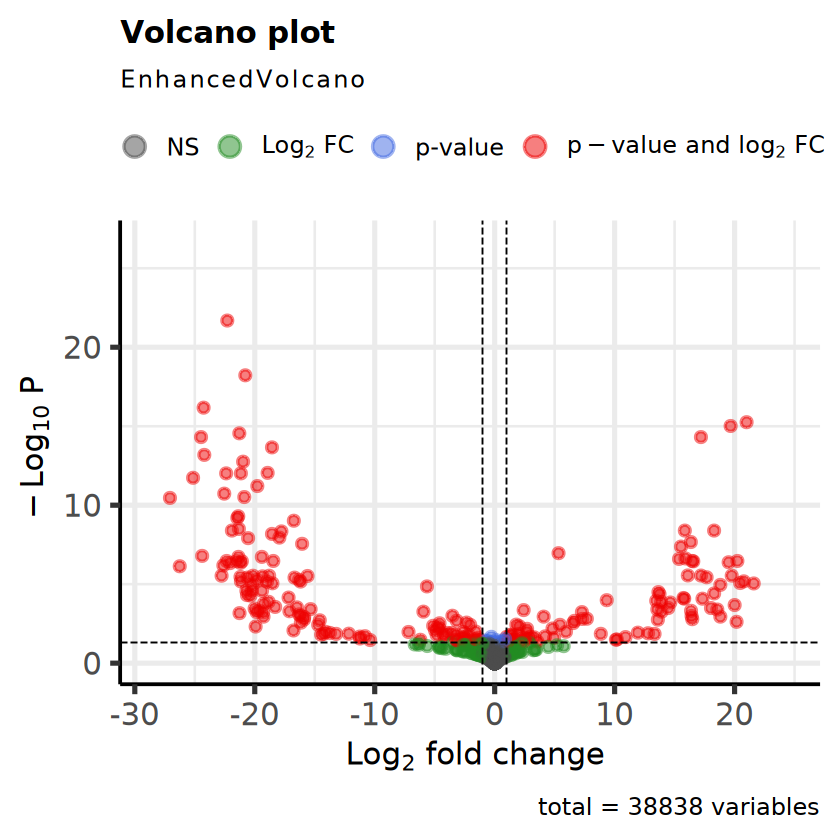

In [194]:
res.hb.bb <- lfcShrink(dds, 
                       coef= 'complete_trtmt_hypoxic.both_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.bb)

EnhancedVolcano(res.hb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [195]:
write.csv(res.hb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_bb.csv')

**WB vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 39, 0.11%
LFC < -1.00 (down) : 46, 0.13%



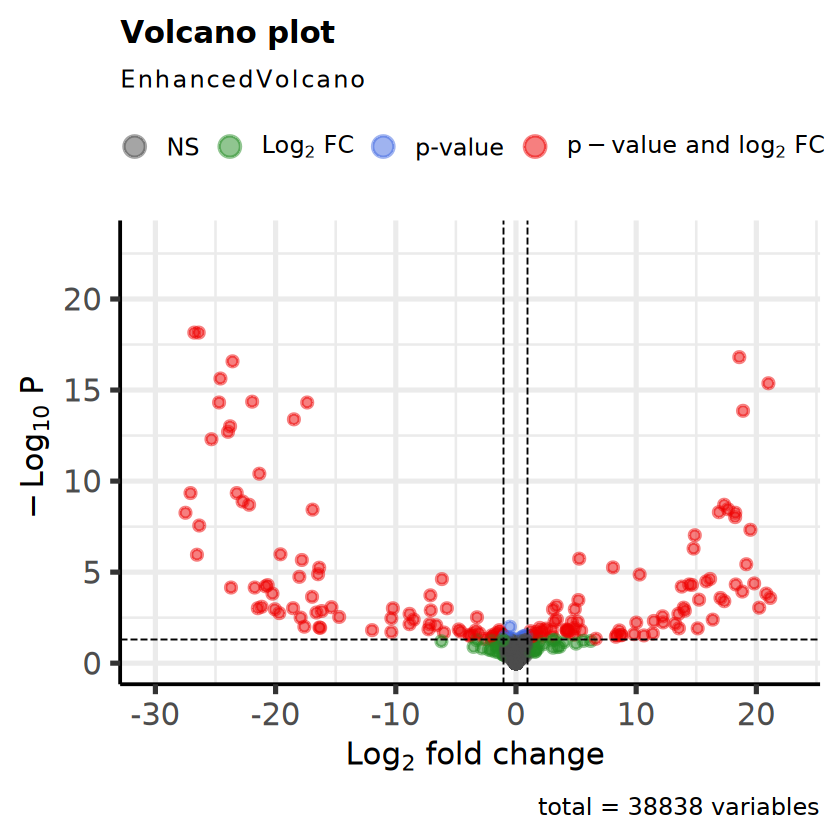

In [196]:
res.wb.bb <- lfcShrink(dds, 
                       coef= 'complete_trtmt_warm.both_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.bb)

EnhancedVolcano(res.wb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [197]:
write.csv(res.wb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_bb.csv')

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 98, 0.28%
LFC < -1.00 (down) : 130, 0.37%



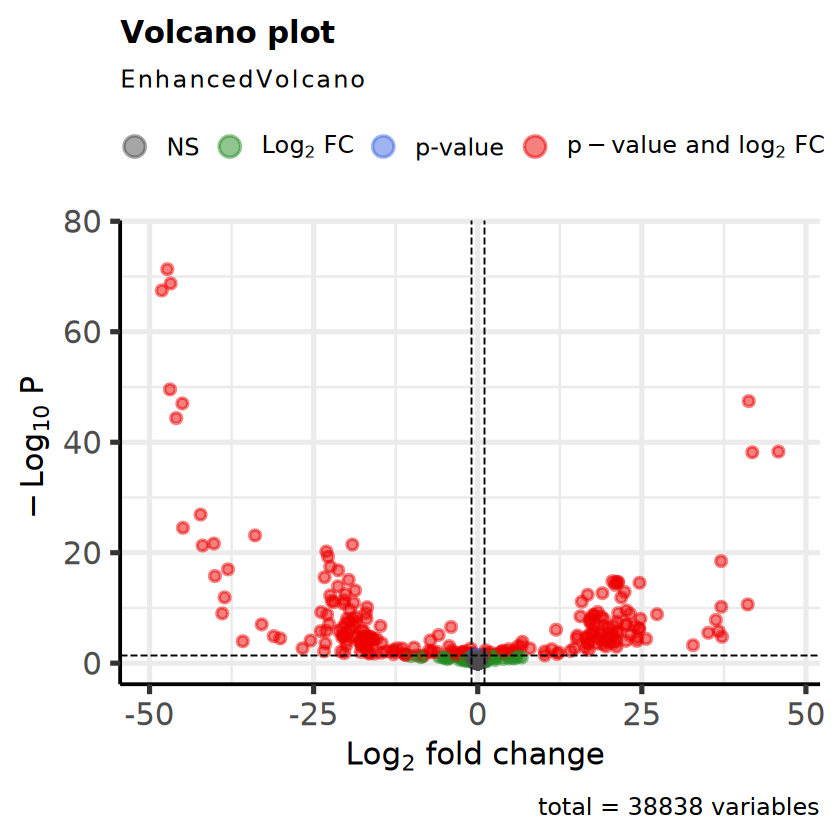

In [198]:
res.hc.ch <- lfcShrink(dds, contrast = c('complete_trtmt', 'hypoxic.control', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hc.ch)

EnhancedVolcano(res.hc.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [199]:
write.csv(res.hc.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hc_ch.csv')

**CW vs. WC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 80, 0.23%
LFC < -1.00 (down) : 76, 0.21%



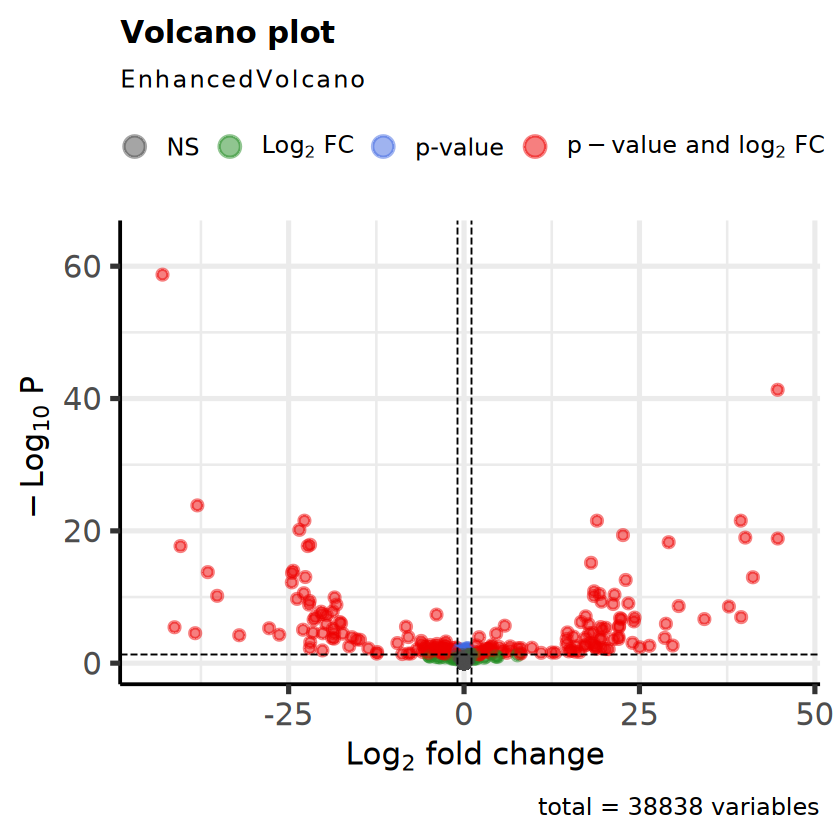

In [200]:
res.wc.cw <- lfcShrink(dds, contrast = c('complete_trtmt', 'warm.control', 'control.warm'), # CW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wc.cw)

EnhancedVolcano(res.wc.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [201]:
write.csv(res.wc.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wc_cw.csv')

**CB vs. BC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 508, 1.4%
LFC < -1.00 (down) : 54, 0.15%



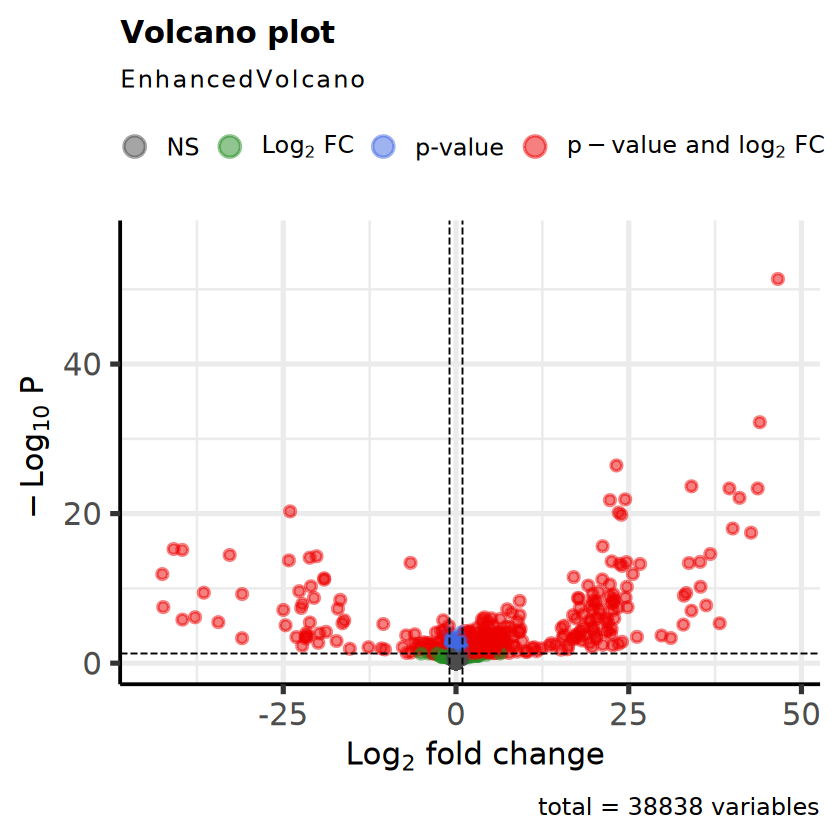

In [202]:
res.bc.cb <- lfcShrink(dds, contrast = c('complete_trtmt', 'both.control', 'control.both'), # CB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.cb)

EnhancedVolcano(res.bc.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [203]:
write.csv(res.bc.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_cb.csv')

### 8. Shared/Unique responses among stressors with ...

#### 8A. ...different *early* stressors
>can compare these with the phase 1 vs. phase 1 DEGs to see if there are similarities
- WC vs. HC: single early stress
- BC vs. HC: mulitple vs. single
- BC vs. WC: multiple vs. single

**WC vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 144, 0.41%
LFC < -1.00 (down) : 70, 0.2%



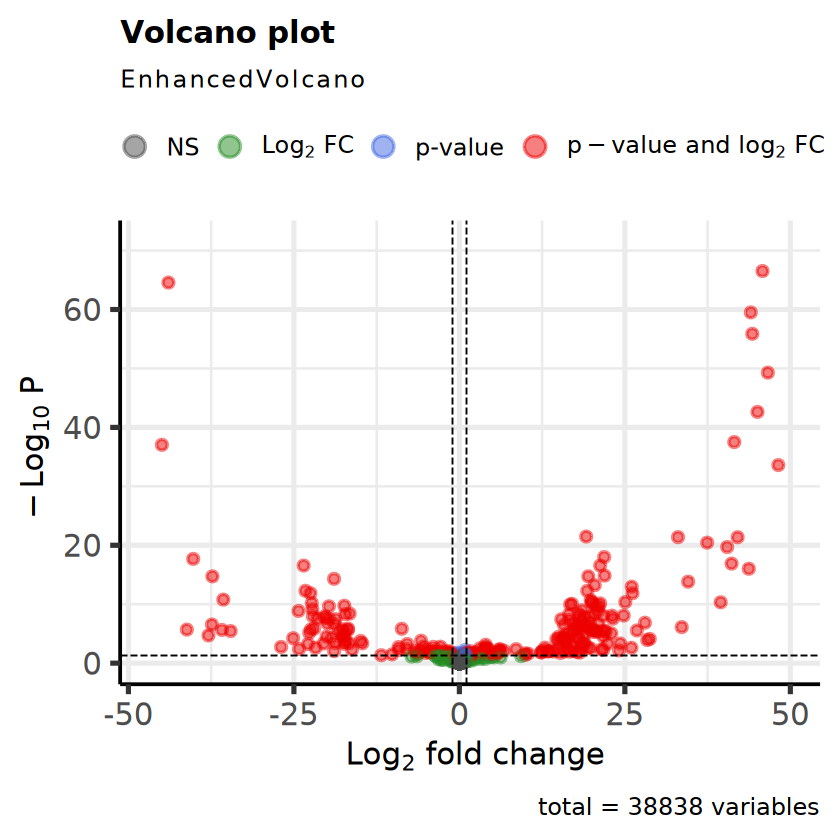

In [204]:
res.wc.hc <- lfcShrink(dds, contrast=c('complete_trtmt', 'warm.control', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wc.hc)

EnhancedVolcano(res.wc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [205]:
write.csv(res.wc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wc_hc.csv')

**BC vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 554, 1.6%
LFC < -1.00 (down) : 41, 0.12%



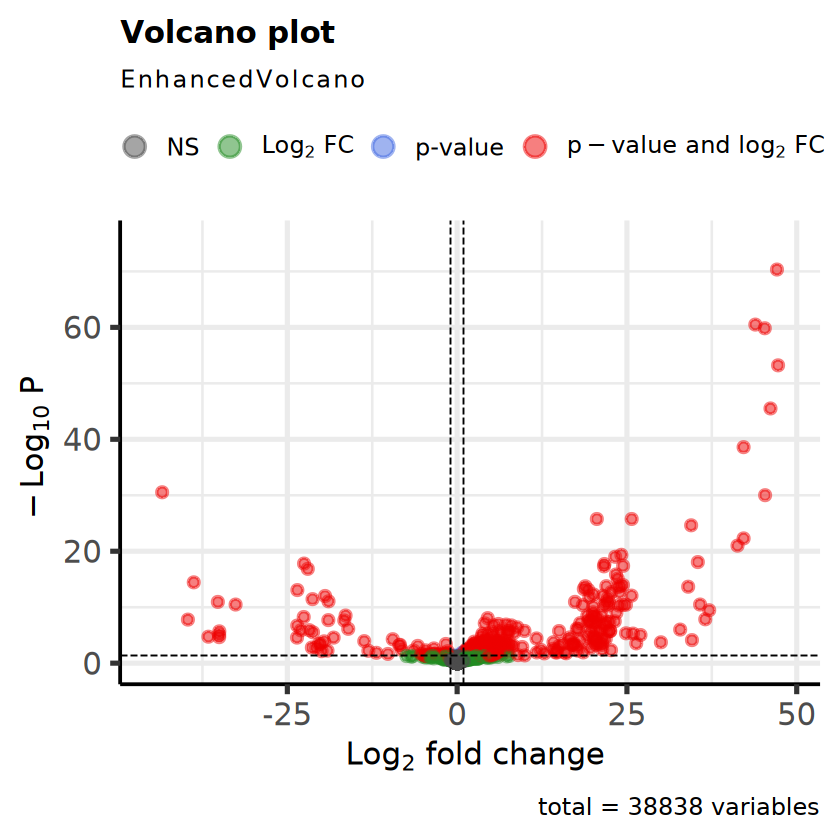

In [206]:
res.bc.hc <- lfcShrink(dds, contrast=c('complete_trtmt', 'both.control', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.hc)

EnhancedVolcano(res.bc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [207]:
write.csv(res.bc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_hc.csv')

**BC vs. WC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 178, 0.5%
LFC < -1.00 (down) : 43, 0.12%



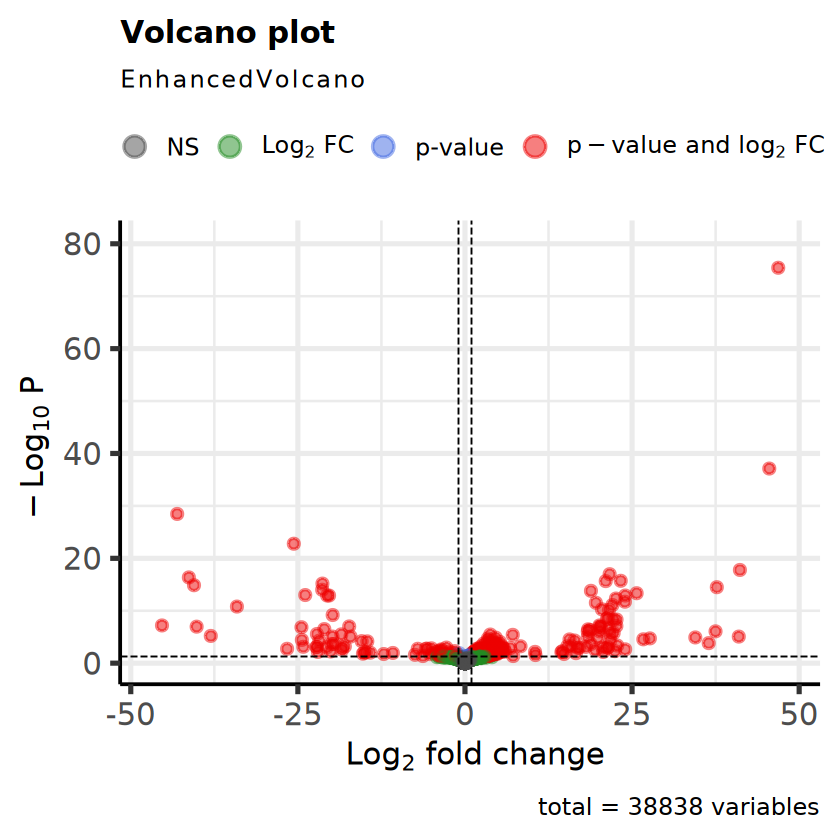

In [208]:
res.bc.wc <- lfcShrink(dds, contrast=c('complete_trtmt', 'both.control', 'warm.control'), # WC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.wc)

EnhancedVolcano(res.bc.wc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [209]:
write.csv(res.bc.wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_wc.csv')

#### 8B. ...different *late* stressors
- CW vs. CH: single early stress
- CB vs. CH: mulitple vs. single
- CB vs. CW: multiple vs. single

**CW vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 127, 0.36%
LFC < -1.00 (down) : 73, 0.21%



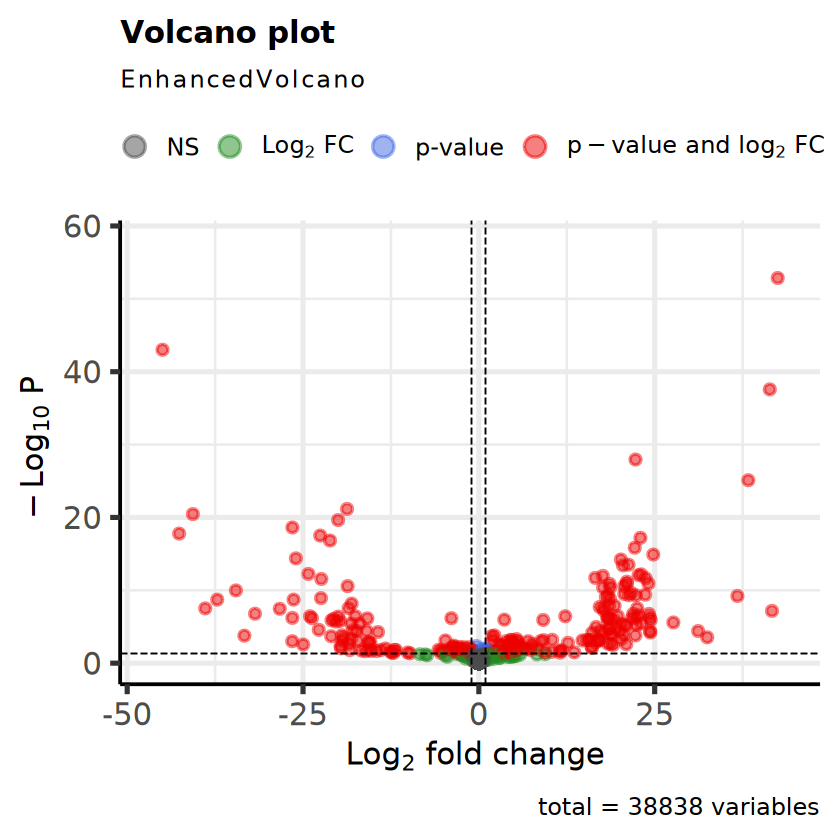

In [210]:
res.cw.ch <- lfcShrink(dds, contrast=c('complete_trtmt', 'control.warm', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cw.ch)

EnhancedVolcano(res.cw.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [211]:
write.csv(res.cw.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cw_ch.csv')

**CB vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 114, 0.32%
LFC < -1.00 (down) : 145, 0.41%



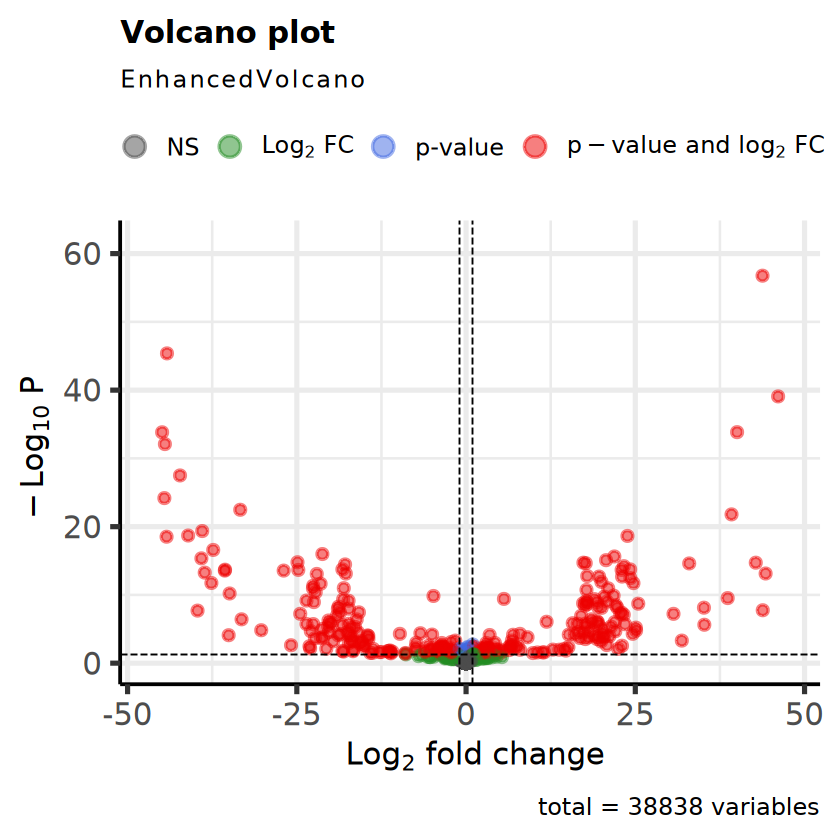

In [212]:
res.cb.ch <- lfcShrink(dds, contrast=c('complete_trtmt', 'control.both', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.ch)

EnhancedVolcano(res.cb.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [213]:
write.csv(res.cb.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_ch.csv')

**CB vs. CW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 77, 0.22%
LFC < -1.00 (down) : 148, 0.42%



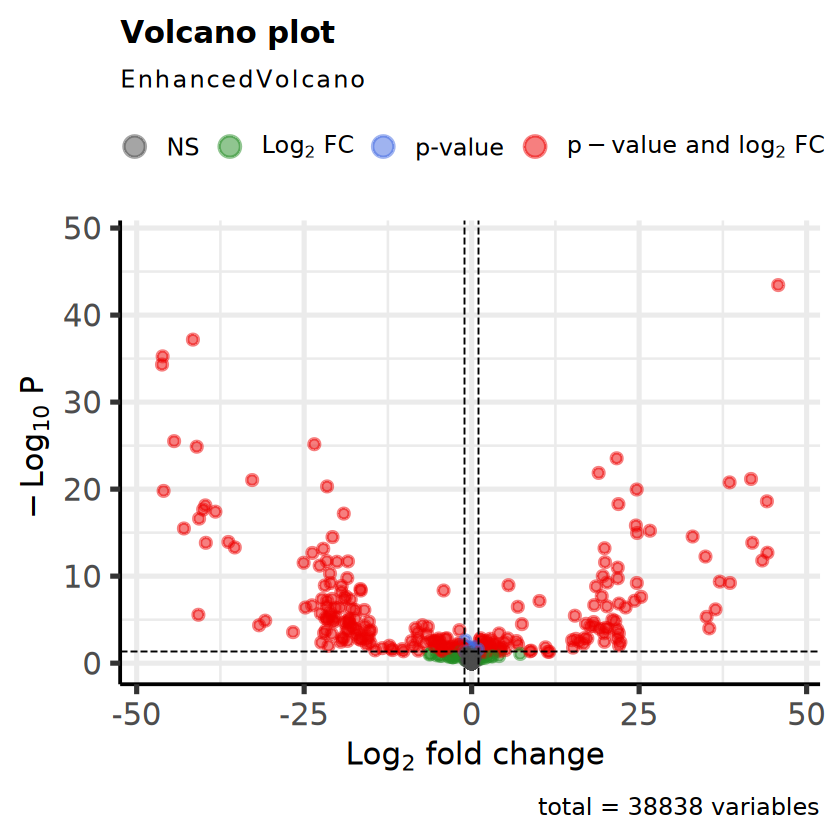

In [214]:
res.cb.cw <- lfcShrink(dds, contrast=c('complete_trtmt', 'control.both', 'control.warm'), # CW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.cw)

EnhancedVolcano(res.cb.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [215]:
write.csv(res.cb.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_cw.csv')

### 9. Effect of the order of stressors
Does the order of when stress is experienced matter? Maybe one stressor is an informative cue for a later environmnet?
- WH vs. HW
- WB vs. BW
- HB vs. BH

**WH vs. HW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 129, 0.36%
LFC < -1.00 (down) : 79, 0.22%



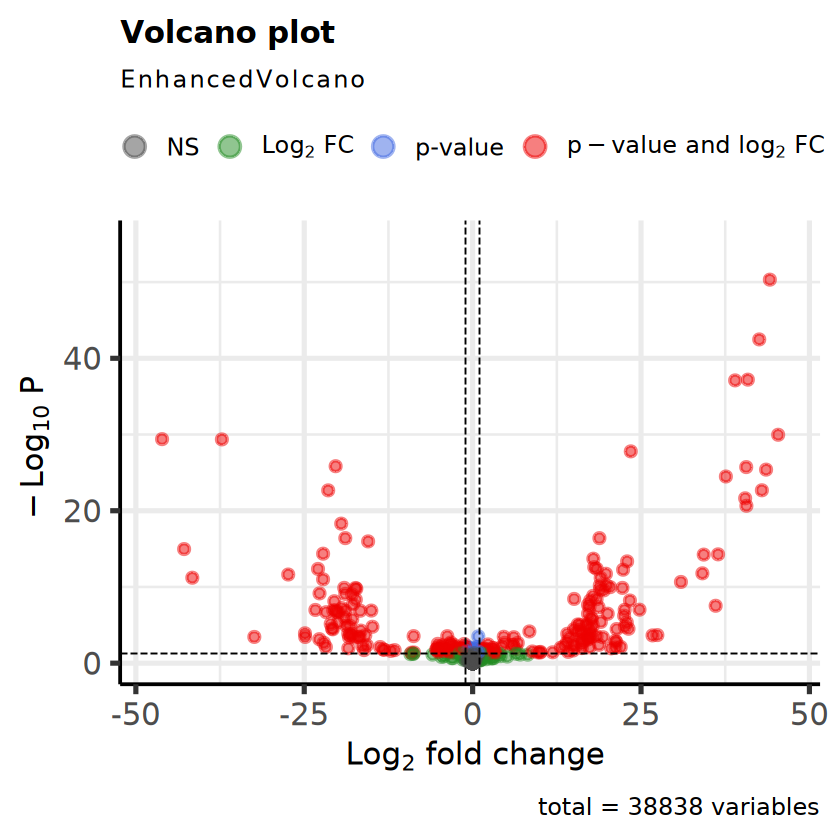

In [216]:
res.wh.hw <- lfcShrink(dds, contrast=c('complete_trtmt', 'warm.hypoxic', 'hypoxic.warm'), # HW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wh.hw)

EnhancedVolcano(res.wh.hw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [217]:
write.csv(res.wh.hw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wh_hw.csv')

**WB vs. BW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 186, 0.53%
LFC < -1.00 (down) : 56, 0.16%



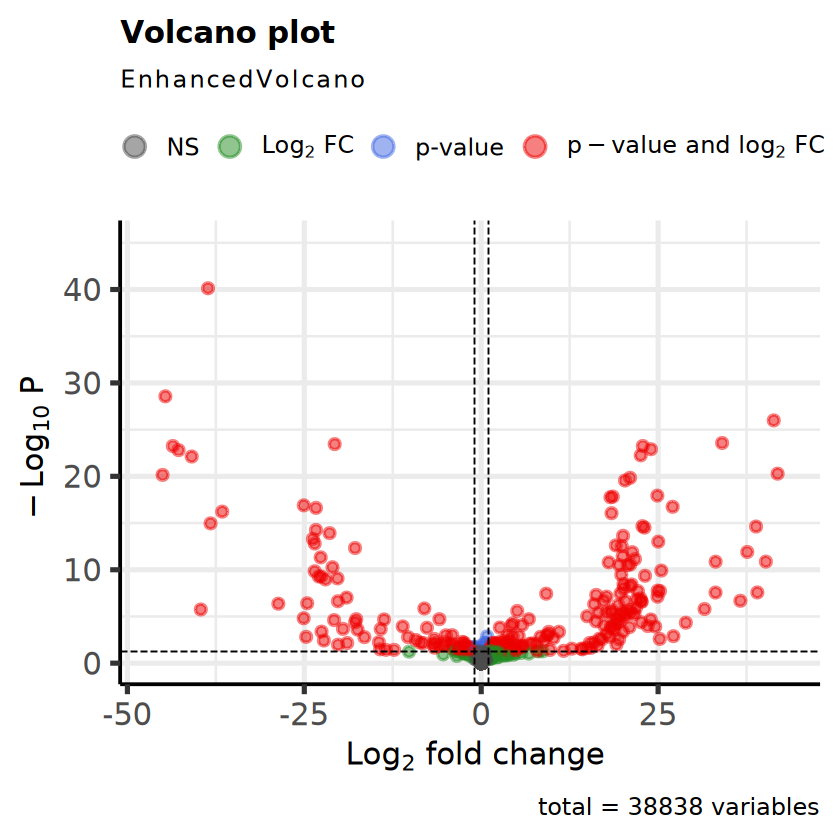

In [218]:
res.wb.bw <- lfcShrink(dds, contrast=c('complete_trtmt', 'warm.both', 'both.warm'), # BW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.bw)

EnhancedVolcano(res.wb.bw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [219]:
write.csv(res.wb.bw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_bw.csv')

**HB vs. BH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35412 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 271, 0.77%
LFC < -1.00 (down) : 80, 0.23%



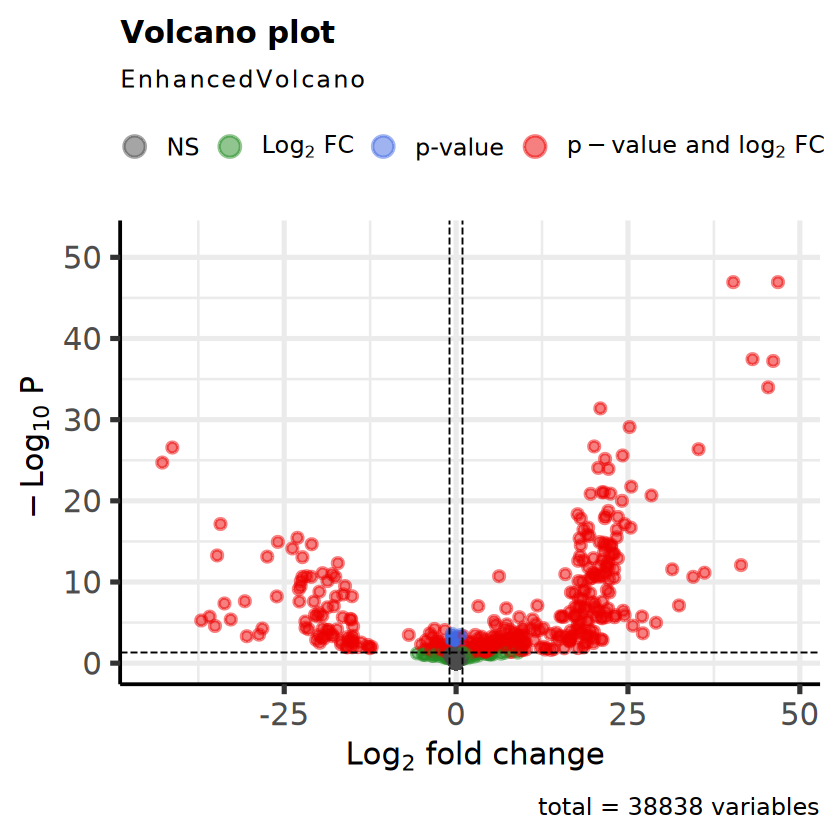

In [220]:
res.hb.bh <- lfcShrink(dds, contrast=c('complete_trtmt', 'hypoxic.both', 'both.hypoxic'), # BH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.bh)

EnhancedVolcano(res.hb.bh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [221]:
write.csv(res.hb.bh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_bh.csv')